# Commute Time and Effective Resistance

**Adrián Arnaiz Rodríguez**

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import networkx as nx
import numpy as np


from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csgraph


import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
#https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
#https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916


from tqdm.notebook import tqdm




import utils.resistance_metrics as ermet
import utils.link_addition as rew
import utils.vis as vis

## Main objective

Homophily or polarization metrics are based in direct link relationships. Those metrics are not optimal, since they are based on local structures, they are "miopic of the overral structure of the network" and they do not really reflect the information flow in the network. The entire structure of the network has a role in the information flow, therefore, diffusion processes over the graph would capture better the isolation or connectivity between different groups in the graph.

However, most of the alternatives to homophily have been proposed in terms of class imbalance, but no closee look at information flow has been analyzed for determining homophily. Information flow has been studied in the problem of over-squashing. Over-squashing refers to... Therefore, what we really would like to measure is, not the direct connections, but the amount of information that one node can send to other. 

From a generalistic label homophily point of view, we can intuitively understand the problems as how much information can flow between the nodes with the same label. The more information are the nodes with label $y_0$ to send information to nodes with the same label $y_0$, the better, specially the better when compared to that information sent to nodes with label $y_1$. In terms of fairness, instead of having $y_0$ and $y_1$, we will have $a_0$ and $a_1$. In that scenario, instead of minimizing $y_0 \rightarrow y_1$ and maximizing $y_0 \rightarrow y_0$, we would like to achive the semi-opposite goal: $a_0 \rightarrow a_0 = a_0 \rightarrow a_1 = a_1 \rightarrow a_1$.

With this goal, we propose effective resistance or commute times. 

*Spectrally*
$$R_{uv} = (\mathbf{e}_u-\mathbf{e}_u)\mathbf{L}^+(\mathbf{e}_u-\mathbf{e}_u) \:\:\text{being}\:\: \mathbf{L}^+=\sum^{n}_{i=2}\frac{1}{\lambda_i} \mathbf{f}_i\mathbf{f}^T$$

$$R_{uv} = \frac{\tau_{uv}}{\text{vol}(G)} = \sum^{n}_{i=2}\frac{1}{\lambda_i} \left(\mathbf{f}_i(u)-\mathbf{f}_i(v)\right)^2$$

$$R_{uv} = \frac{\tau_{uv}}{\text{vol}(G)} = \frac{||\mathbf{Z}_{u,:}-\mathbf{Z}_{v,:}||^2}{\text{vol}(G)} \:\:\text{being}\:\: \mathbf{Z}=\sqrt{\text{vol}(G)}\Lambda^{-\frac{1}{2}}\Phi^T$$

*Optmization problem*

$$R_{uv} = \frac{\tau_{uv}}{\text{vol}(G)} = \frac{||\mathbf{Z}_{u,:}-\mathbf{Z}_{v,:}||^2}{\text{vol}(G)} \:\:\text{being}\:\ \mathbf{Z}=\arg \min_{\mathbf{Z}^T\mathbf{Z}=\mathbf{I}} \frac{\text{Tr}\left[\mathbf{Z}^T\mathbf{L}\mathbf{Z}\right]}{\text{Tr}\left[\mathbf{Z}^T\mathbf{D}\mathbf{Z}\right]}$$

These are the following advantages and relation with prior work:

* Theoretically why:
    * CT is be definition the convergence of **Random Walk**: Expected number of steps...
    * CT is the convergence of **k hops *without parameters $\alpha$ and $k$***.
    * CT better than Jacobian: DeGiovanni
    * CT is totally related with over-squashing and cheeguer: works from topping to the last relating everything (words from Rishabh).
    * CT betten than Signal Propagation.
    * CT is the cusp of all the **diffusion processes** over the graph: based on spectral metrics.
    * Relation to Structural PCA!!

## CT as information access

**Graph metrics**

* ***Proper from graphs***
1. **Societal ease of information: *Total Effective Resistance*** (Di Giovanni 2023 and Effective graph resistance)
    * By Rayleigh’s monotonicity principle, it always decreases when adding new edges, but some edges will make it decrease more than others
    
$$\text{Res}_G = \sum_{(v,u) \in V} \text{Res}(v, u) = |V| \sum_2^{|V|} \frac{1}{\lambda_n} = \mathbf{1R1}^T$$

Since the distance between $u$ and $v$ is the euclidean distance in the embedding, then, we can also definde $\text{Res}_G$ as follows. [Ghosh 2008]

$$\text{Res}_G = \sum_{(v,u) \in V} \text{Res}(v, u) = \sum_{(v,u) \in V} ||x_u - x_v||^2 = n \sum_{u \in V} ||x_u||^2 $$
    
2. [Prop to G.1] **Avg Societal ease of information: *Total Effective Resistance normalized by number of nodes***

$$\overline{\text{Res}_G}=\frac{\text{Res}_G}{|V|}$$

3. **Worst case information access: *Resistance Diameter***  (Graph Clustering using Effective Resistance (Alev et al) and DiffWire)
 (Ellens et al))
 
$$\mathcal{R}_{diam} = \max_{u,v \in V} \text{Res}(u,v)$$

* ***Sumary of node metrics***
4. *Avg Node Societal ease of information: Average of individual total (N.1) [equal to G.2 - Prop to G.1] or avg ER (N.2)*

$$\overline{\text{Res}_G(V)}= \frac{1}{|V|}\sum_{u} \text{Res}_G(u) = \mathbf{2\times \overline{\text{Res}_G}}$$

$$\overline{\overline{\text{Res}_G(V)}}= \frac{1}{|V|}\sum_{u} \overline{\text{Res}_G(u)} = \mathbf{\frac{1}{|V|} 2\times \overline{\text{Res}_G}}$$

5. **Worst case average information access: *Average of Resistance Diameter for every node***

$$ \overline{\mathcal{R}_{diam}(V)} = \frac{1}{|V|} \sum_{u\in V} \mathcal{R}_{diam}(u)$$

**We really have only 3 different metrics ($\text{Res}_G$, $\mathcal{R}_{diam}$ and $\overline{\mathcal{R}_{diam}(V)}$) since all the others are proportional to $\text{Res}_G$:**

$$\text{Res}_G = |V| \times \overline{\text{Res}_G} = |V| \times \frac{\overline{\text{Res}_G(V)}}{2}= |V|^2 \times \frac{\overline{\overline{\text{Res}_G(V)}}}{2}$$


6. **Average or maximum resistance betweeness** ***ToDo***

$$\overline{\mathsf{Res}_G(u, \mathcal{N})}$$ or $$\max_{u \in V} \mathsf{Res}_G(u, \mathcal{N})$$

**Node metrics**

1. **Total ease of info node**

$$\text{Res}_G(u) = \sum_{v} \text{Res}(u, v)$$

2. [Prop to N.1] **Avg ease of info node**

$$\overline{\text{Res}_G(u)} = \frac{1}{|V|}\sum_{v} \text{Res}(u, v)$$

3. **Total Filtered ER**: Related to betweenes.
    * ER: betweenes of an edge --> sum of existing edges ER to a node --> node betweeness

$$\text{Res}_G(u, \mathcal{N}) = \sum_{v \in \mathcal{N}(u)} \text{Res}(u, v)$$

4. **Avg ease of info node**

$$\mathcal{R}_{diam}(u) = \max_{v \in V} \text{Res}(u,v)$$


## CT as homophily

Take into account for normalization: volume of graph, total effective resistance (Rayleighs monocity)

* One CT measure for each node (mean distance to everyone)
* CT distribution difference between same class and different one
<img src="robustHomophily.png"  width="60%" height="30%">
* GE with label vector instead of opinion (Hohmann, Devriednt & Coscia, 2023) **network distance between all pairs weighted by how strongly they hold their opinions. But, Do I really need the weighted in clf? Sure for regression!**
$$
h=\sqrt{(y_1-y_0)^T L^+ (y_1-y_0)} \:\: \in \:\: \left[0, +\inf\right]
$$


## Main Alternatives

* LI
* Signal Propagation
* Jacobbian
* MaxFair
* GUIDE EDITS - K-hops
* Heat Kernel
* Vector Distance - **Quantifying network distance between all pairs weighted by how strongly they hold their opinions**.
* FAccT 23

## Main Datasets

**Synthetic**

* Structural
    * Hand-made from papers: maxfair and LI papers
    * SBM
    * *Survey on graph* and *all edges with optimal transport*
    * Different model generators: Erdós-Renyi, Watz-Stotgart...
    * Clique-Path, Ring, ETC
    * Look more structural generators in papers
* Structural-Label
    * Analyze papers and ppts with ideas
    * Label vector in correlation with eigenvectors or not
    
* More
    * SBM: from 2 no $N$ communities with differents $p_{in}$ and $p_{out}$ (hohmann, Devriednt and Coscia, 2023)
    * Watts-Stotgart
    * Erdos-Renyi
    * Preferential attachment: Barabassi-Albert
    * Barrel, cycle, chain

**Real-World**
* Paper: *Quantifying ideological polarization on a network using generalized Euclidean distance*
* Fairness datasets
* FAcct 2023
* Survey on graphs [github](https://github.com/manvic14/Survey_Fairness_Graphs)
* anotated in markdown





**Real World**
* Cora and so on from PyG with social component for Link Classification
* Twitter, Pokec, USA elections
* FaccT23 paper
| Name        | Nodes | Edges  | Max Deg. | Diam. |
|-------------|-------|--------|----------|-------|
| Email-EU    | 803   | 24729  | 338      | 5     |
| Email-Arenas| 1133  | 5451   | 71       | 8     |
| Irvine      | 1294  | 19026  | 231      | 7     |
| Facebook    | 4039  | 88234  | 1045     | 8     |
| ca-GrQc     | 4158  | 13428  | 81       | 17    |
| ca-HepTh    | 8638  | 24827  | 65       | 18    |

* Another Facct 23 paper
|Dataset| Sensitive Attribute | V | E| Groups Assortativity|
|-------------|-------|--------|----------|-------|
PolBlogs [2] |Political Party |1, 222| 19, 024 |2 |0.811
Email-EU [117]| Department |339 |7, 066 |8 |0.722
Lastfm-Asia [98]| Country |2, 785 |17, 017 |9 |0.90
Deezer-Europe [98]| Gender |1, 090 |3, 623| 2 |0.016

* Survey on graph Fairness
| Properties     | # of nodes | # of edges |
|----------------|-----------|------------|
| PolBlogs       | 1,490     | 19,090     |
| Facebook-E     | 4,039     | 88,234     |
| Pokec-z        | 67,797    | 617,958    |
| Pokec-n        | 66,569    | 517,047    |
| LastFM         | 7,624     | 27,806     |
| Facebook-P     | 22,470    | 171,002    |
| MovieLens-1M       | 6,040     | 1,000,209  |
| MovieLens-100K     | 3,900     | 100,000    |
| DBLP               | 943       | 6,965      |
| Reddit             | 3,980     | 366,797    |
| Google+            | 385,735   | 547,923    |
| NBA                | 4,938     | 10,621     |

**Example of squareform**

Symmetric matrix to vector and viceverse

In [3]:
squareform([1,2,3,4,5,6])

array([[0, 1, 2, 3],
       [1, 0, 4, 5],
       [2, 4, 0, 6],
       [3, 5, 6, 0]])

In [4]:
squareform([[0, 1, 2, 3],
            [1, 0, 4, 5],
            [2, 4, 0, 6],
            [3, 5, 6, 0]])

array([1, 2, 3, 4, 5, 6])

In [5]:
np.array([[0, 1, 2, 3],
[1, 0, 4, 5],
[2, 4, 0, 6],
[3, 5, 6, 0]])[np.triu_indices(4,k=1)]

array([1, 2, 3, 4, 5, 6])

## Spectral Utils

In [6]:
def psudoinverseL(network):
    A = nx.adjacency_matrix(network).todense().astype(float)
    return np.linalg.pinv(csgraph.laplacian(np.matrix(A), normed=False))

def find_evecs(L):
    e, evecs = np.linalg.eig(L.todense())
    idx =e.argsort()
    e = e[idx]
    evecs = evecs[:,idx]
    return e, evecs

def plot_eigenvalues(eigenvalues):  
    idx = range(len(eigenvalues))
    y = np.asarray(eigenvalues)
    plt.plot(idx, y, 'r')
    plt.xlabel('# Eigenvalues')
    # show the plot
    plt.show()


def plot_eigenvector_over_graph(G, evecs, k, ax, seed=63):
    """Plot the k-th Laplacian Eigenvalue on the Graph"""
    # Extract eigenvector from the evecs matrix and transform into dim (n,)
    u = np.array(np.real(evecs[:,k]))
    u = np.squeeze(np.transpose(u))
    v = u + 100 #avoid negatives for plotting colors properly
    
    
    # Draw the graph 
    pos = nx.spring_layout(G, seed=seed)  # Seed layout for reproducibility
    nx.draw(G, pos, node_color=v, node_size=300, cmap=plt.cm.seismic, ax=ax)
    sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=u.min(), vmax=u.max()))
    #sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.show()

**UTILS**: Commute Times and Effective resistance Metrics

In [7]:
def graph_vol(G):
    return nx.adjacency_matrix(G).sum()

def degree_matrix(G):
    A = nx.adjacency_matrix(G)
    return np.diag(A.sum(axis=1))
    

def commute_times_embedding(G, e, evecs):
    "Return CT embeddings in columns"
    #get basic data from graph
    vol = graph_vol(G)
    A = nx.adjacency_matrix(G)
    #Prepare spectral ingredients
    Phi = evecs
    Lambda = np.diag(e)
    # Lambda up to -1/2 needed in CTE formula
    Lambda = fractional_matrix_power(Lambda, -0.5)
    Lambda[0,0] = 0
    # Embedding is in the columns
    CTE = np.sqrt(vol)*np.matmul(Lambda,np.transpose(Phi))
    return np.real(CTE)

def commute_times(G, e, evecs, resistance=False):
    #get basic data from graph
    vol = graph_vol(G)
    CTE = commute_times_embedding(G, e, evecs)
    # Embedding is in the columns and we move it to the rows
    CT = pdist(np.transpose(CTE), 'euclidean')
    CT = squareform(CT)
    if resistance:
        CT = CT/vol
    return CT

# Plot the CT distance on the Graph
def plot_commute_times_over_graph(G, e, evecs, ax, CT=None, options=None):
    # Compute CT
    if CT is None:
        CT = commute_times(G, e, evecs, False)
    # From the commute times extract the colors of the edges
    E = G.edges()
    u = np.zeros(G.number_of_edges())
    k = 0 
    for e in E: 
        i = e[0]
        j = e[1]
        u[k] = CT[i,j]*100 
        k = k + 1   
    # Create the color map
    pos = nx.kamada_kawai_layout(G)
    
    if options is None:
        options = {
            "node_color": "#A0CBE2",
            "edge_color": u,
            "width": 2,
            "edge_cmap": plt.cm.seismic,
            "with_labels": True,
        }
    else:
        options["edge_color"]= u
    # Draw the graph
    nx.draw(G, pos, **options, ax=ax)
    sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=u.min(), vmax=u.max()))
    #sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.show()

**Coscia**

**We test the basic properties of effective resistance:**
 * Different ways of computing effective resistance
 * Different ways of computing total effective resistance

In [8]:
sizes = [50, 50]
gap_prob = 0.01
intra_prob = 0.8
probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

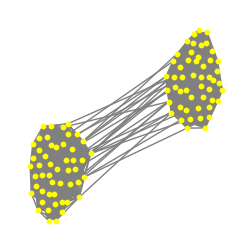

In [9]:
f, ax = plt.subplots(figsize=(3,3))
nx.draw(G, ax=ax, node_size=10, node_color="yellow", edge_color="grey")
plt.show()

In [10]:
evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

In [11]:
R = ermet.effective_resistance_matrix(G)
R_set = squareform(R.round(10))

B = ermet.biharmonic(G)
B_set = squareform(B.round(10))

In [12]:
R_tot_eigen = G.number_of_nodes()*np.sum(1/evl[1:])
R_tot = R.sum()
R_tot_set = R_set.sum()
R_tot_matrix = np.matrix(np.ones(R.shape[0]))*R*np.matrix(np.ones(R.shape[0])).T
R_tot_matrix = R_tot_matrix[0,0]


B_tot_eigen = G.number_of_nodes()*np.sum(1/(evl[1:]**2))
B_tot = B.sum()
B_tot_set = B_set.sum()
B_tot_matrix = np.matrix(np.ones(B.shape[0]))*B*np.matrix(np.ones(B.shape[0])).T
B_tot_matrix = B_tot_matrix[0,0]

In [13]:
R_tot_eigen, R_tot/2, R_tot_set, R_tot_matrix/2

(361.4979872587133, 361.49798725871375, 361.4979872558, 361.4979872587138)

In [14]:
B_tot_eigen, B_tot/2, B_tot_set, B_tot_matrix/2

(139.10263618897935, 139.10263618898128, 139.1026361866, 139.10263618898128)

It does not work with the current implementation of CT so far

## Little visualization of CTs, total (effective) REs and Diam Res calculated using 2 different functions

* Graph Clustering using Effective Resistance: https://drops.dagstuhl.de/opus/volltexte/2018/8369/pdf/LIPIcs-ITCS-2018-41.pdf
* Effective Resistance: https://www.nas.ewi.tudelft.nl/people/Piet/papers/LAA_2011_EffectiveResistance.pdf

In [15]:
@interact
def interactive_CT_SBM(intra=(0.1,1,0.1),inter=(0.0,0.1,0.01)):
    sizes = [50, 50]
    gap_prob = inter
    intra_prob = intra
    probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
    G = nx.stochastic_block_model(sizes, probs)#, seed=0)
    
    evl, evc = find_evecs(nx.laplacian_matrix(G))
    evl = np.real(evl)
    evc = np.real(evc)
    
    fig, ax = plt.subplots(figsize=(5,3))
    plot_eigenvector_over_graph(G, evc, 1, ax)
    
    #Plot CTs
    f, axs = plt.subplots(2,2, figsize=(12,6))
    
    axs[0][0].imshow(ermet.effective_resistance_matrix(G))
    axs[0][0].set_title("Coscia Code")
    
    axs[0][1].imshow(commute_times(G, evl, evc, resistance = True))
    axs[0][1].set_title("OUR Code")

    cos_res = ermet.effective_resistance_matrix(G)
    axs[1][0].hist(cos_res[np.triu_indices(np.sum(sizes),k=1)].ravel(), bins=80)
    
    title = f"""Total: {ermet.total_effective_resistance(cos_res):.1e} = \n"""
    title += f"""V * (Total/V): {G.number_of_nodes()}*{ermet.total_effective_resistance(cos_res,mean = True):.1e} ="""
    title += f"""{G.number_of_nodes()*ermet.total_effective_resistance(cos_res,mean = True):.1e} = \n"""
    title += f"""V* Avg total/2: {G.number_of_nodes()}*{ermet.avg_node_total_er(cos_res):.1e}/2 = """
    title += f"""{G.number_of_nodes()*ermet.avg_node_total_er(cos_res)/2 :.1e} = \n"""
    title += f"""V*V* Avg mean/2: {G.number_of_nodes()**2}*{ermet.avg_node_mean_er(cos_res):.1e} ="""
    title += f"""{G.number_of_nodes()**2*ermet.avg_node_mean_er(cos_res)/2:.1e}\n"""
    title += "-----------\n"
    title += f"""Diam: {ermet.resistance_diameter(cos_res):.1e}\n"""
    title += f"""Avg Diam: {ermet.avg_node_max_distance(cos_res):.1e}\n"""
        
    axs[1][0].set_title(title)

    try:
        ct_res = commute_times(G, evl, evc, resistance = True)
        axs[1][1].hist(ct_res[np.triu_indices(np.sum(sizes),k=1)].ravel(), bins=80)
        title = f"""Total: {ermet.total_effective_resistance(ct_res):.1e}\n"""
        title += f"""Total/V: {ermet.total_effective_resistance(ct_res,mean = True):.1e}\n"""
        title += f"""Diam: {ermet.resistance_diameter(ct_res):.1e}\n"""
        title += f"""Avg total: {ermet.avg_node_total_er(ct_res):.1e}\n"""
        title += f"""Avg mean: {ermet.avg_node_mean_er(ct_res):.1e}\n"""
        title += f"""Avg Diam: {ermet.avg_node_max_distance(ct_res):.1e}\n"""
        
        axs[1][1].set_title(title)
    except:
        axs[1][1].text(0.5, 0.02, "Fail: NAN in CT computation", fontsize=18)
    
    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='intra', max=1.0, min=0.1), FloatSlider(value=0.05, d…

In [16]:
def plot_total_and_sum(loop_intra=True):
    sizes = [50, 50]
    
    cosc_res_list = {"total":[],"diam":[], "total_filtered":[]}
    ct_res_list = {"total":[],"diam":[], "total_filtered":[]}
    
    if loop_intra:
        loop_values = np.linspace(0.1,1,10)
        fixed_val=0.01
    else:
        loop_values = np.linspace(0.01,0.1,10)
        fixed_val=0.8
     
    for i in loop_values:
        gap_prob = fixed_val if loop_intra else i
        intra_prob = i if loop_intra else fixed_val
    
        probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
        G = nx.stochastic_block_model(sizes, probs)#, seed=0)

        evl, evc = find_evecs(nx.laplacian_matrix(G))
        evl = np.real(evl)
        evc = np.real(evc)
        
        cos_res = ermet.effective_resistance_matrix(G)
        total= ermet.total_effective_resistance(cos_res)
        diam = ermet.resistance_diameter(cos_res)
        diam_f = np.std(ermet.node_total_er(cos_res, G, filtered=True))
        #diam_f = np.max(ermet.node_total_er(cos_res, G, filtered=True))
        cosc_res_list["total"].append(total) 
        cosc_res_list["diam"].append(diam)
        cosc_res_list["total_filtered"].append(diam_f)
        

        ct_res = commute_times(G, evl, evc, resistance = True)
        total = ermet.total_effective_resistance(ct_res)
        diam = ermet.resistance_diameter(ct_res)
        diam_f = ermet.total_effective_resistance(ct_res, G, filtered=True)
        diam_f = ermet.total_effective_resistance(ct_res, G, filtered=True)
        diam_f = np.std(ermet.node_total_er(ct_res, G, filtered=True))
        ct_res_list["total"].append(total) 
        ct_res_list["diam"].append(diam)
        ct_res_list["total_filtered"].append(diam_f)
        
    return cosc_res_list, ct_res_list, loop_values
    


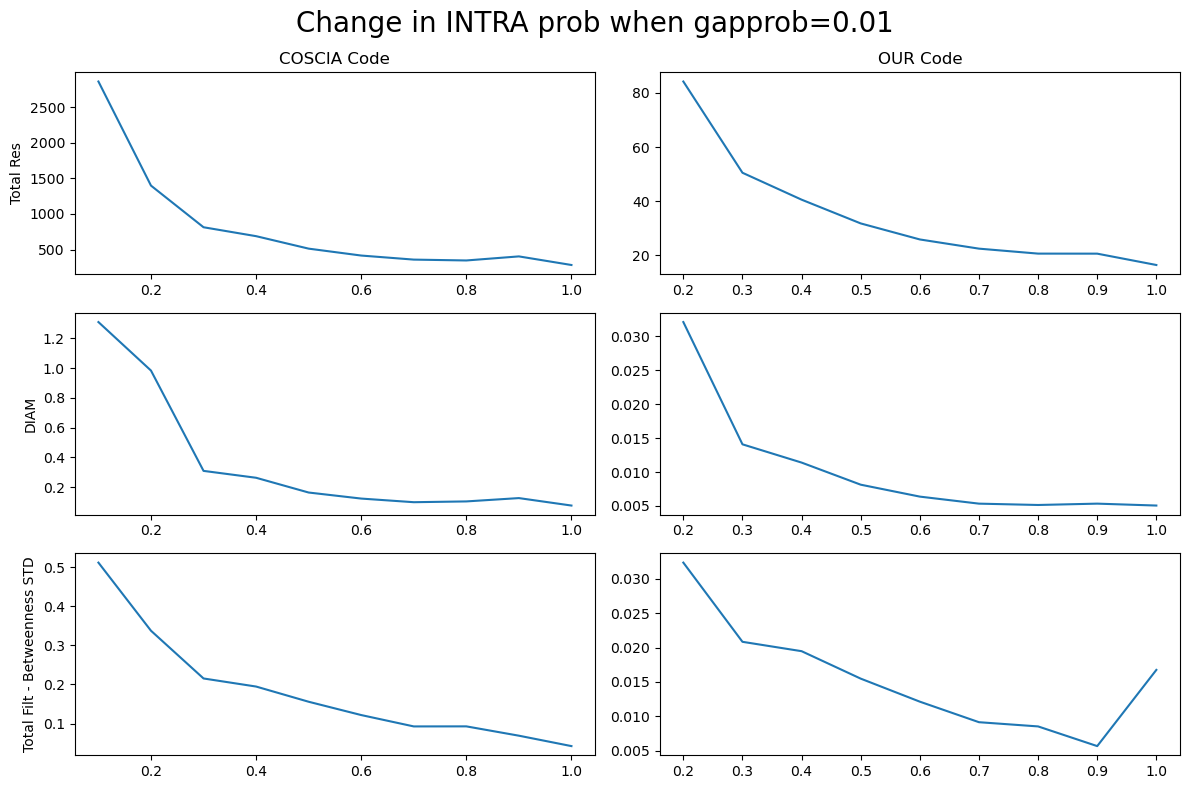

In [17]:
csdict, ctdict, xaxes = plot_total_and_sum(loop_intra=True)
f, axs = plt.subplots(3,2, figsize=(12,8))

axs[0][0].set_title('COSCIA Code')
axs[0][0].set_ylabel('Total Res')
axs[0][0].plot(xaxes, csdict['total'])
axs[0][1].set_title('OUR Code')
axs[0][1].plot(xaxes, ctdict['total'])

axs[1][0].set_ylabel('DIAM')
axs[1][0].plot(xaxes, csdict['diam'])
axs[1][1].plot(xaxes, ctdict['diam'])

axs[2][0].set_ylabel('Total Filt - Betweenness STD')
axs[2][0].plot(xaxes, csdict['total_filtered'])
axs[2][1].plot(xaxes, ctdict['total_filtered'])



plt.suptitle('Change in INTRA prob when gapprob=0.01', fontsize=20)
plt.tight_layout()
plt.show()

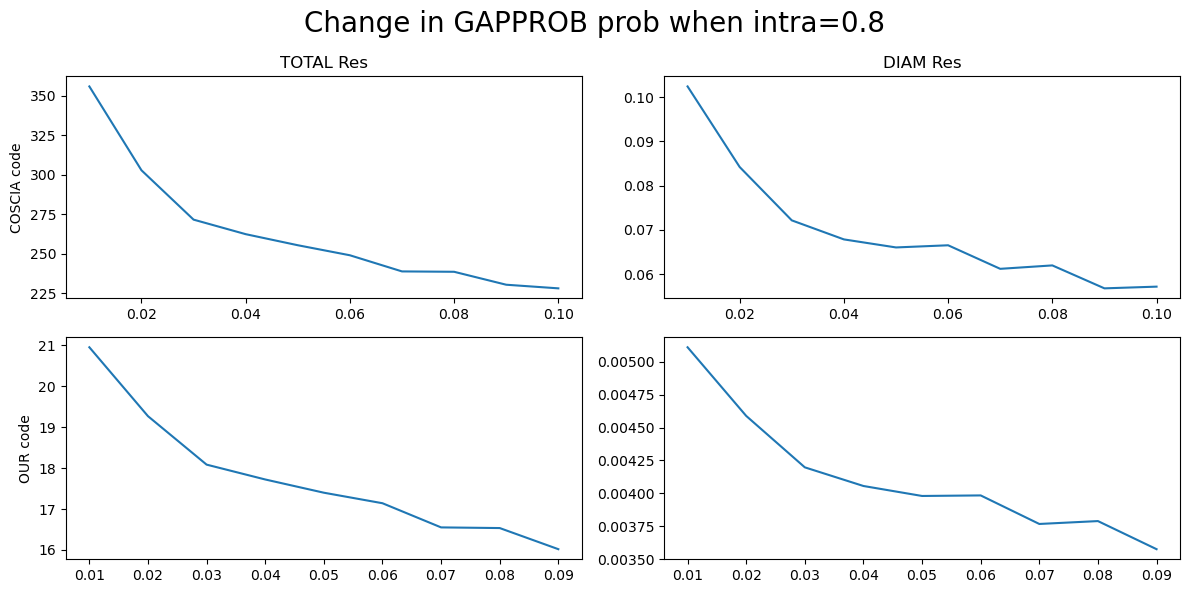

In [18]:
csdict, ctdict, xaxes = plot_total_and_sum(loop_intra=False)
f, axs = plt.subplots(2,2, figsize=(12,6))

axs[0][0].plot(xaxes, csdict['total'])
axs[0][0].set_title('TOTAL Res')
axs[0][0].set_ylabel('COSCIA code')
axs[0][1].plot(xaxes, csdict['diam'])
axs[0][1].set_title('DIAM Res')
axs[1][0].plot(xaxes, ctdict['total'])
axs[1][0].set_ylabel('OUR code')
axs[1][1].plot(xaxes, ctdict['diam'])


plt.suptitle('Change in GAPPROB prob when intra=0.8', fontsize=20)
plt.tight_layout()
plt.show()

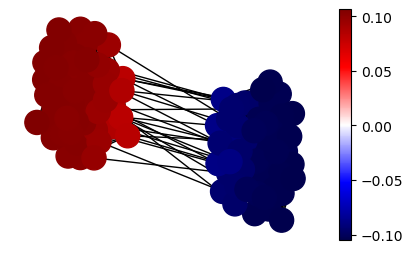

In [19]:
sizes = [50, 50]
gap_prob = 0.01
intra_prob = 0.5
probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

fig, ax = plt.subplots(figsize=(5,3))
plot_eigenvector_over_graph(G, evc, 1, ax)

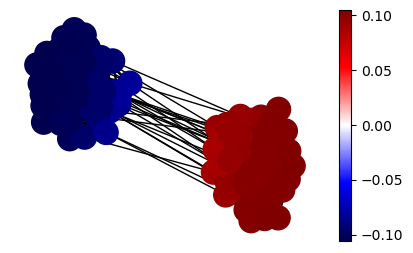

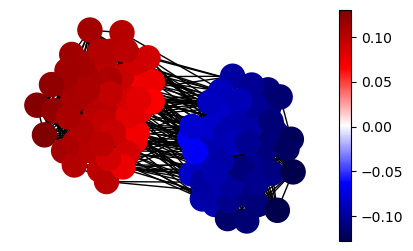

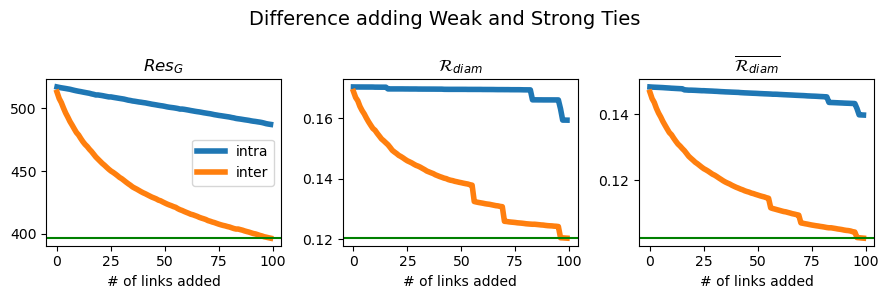

In [20]:
from random import choice

G_intra = G.copy()
G_inter = G.copy()
com1 = np.where(np.array(evc[:,1]).squeeze() < 0)[0]
com2 = np.where(np.array(evc[:,1]).squeeze() > 0)[0]

intra_data = {"total":[],"diam":[], "diam_filtered":[], "avg_node_diameter":[], "avg_node_total_er":[]}
inter_data = {"total":[],"diam":[], "diam_filtered":[], "avg_node_diameter":[], "avg_node_total_er":[]}

for i in range(100):
    
    u = choice(list(G.nodes()))
    v_intra = choice(com1) if evc[u,1]<0 else choice(com2)
    v_inter = choice(com2) if evc[u,1]<0 else choice(com1)
    
    while G.has_edge(u, v_intra) or G.has_edge(u, v_inter) or u == v_intra:
        v_intra = choice(com1) if evc[u,1]<0 else choice(com2)
        v_inter = choice(com2) if evc[u,1]<0 else choice(com1)

        
    G_intra.add_edge(u,v_intra)
    cos_res = ermet.effective_resistance_matrix(G_intra)
    total= ermet.total_effective_resistance(cos_res)
    diam = ermet.resistance_diameter(cos_res)
    diam_f = ermet.resistance_diameter(cos_res, G_intra, filtered=True)
    diam_avg = ermet.avg_node_max_distance(cos_res)

    intra_data["total"].append(total) 
    intra_data["diam"].append(diam)
    intra_data["diam_filtered"].append(diam_f)
    intra_data["avg_node_diameter"].append(diam_avg)
    
    if i % 1==0:
        G_inter.add_edge(u,v_inter)
        cos_res = ermet.effective_resistance_matrix(G_inter)
        total= ermet.total_effective_resistance(cos_res)
        diam = ermet.resistance_diameter(cos_res)
        diam_f= ermet.resistance_diameter(cos_res, G_inter, filtered=True)
        diam_avg = ermet.avg_node_max_distance(cos_res)

        inter_data["total"].append(total) 
        inter_data["diam"].append(diam)
        inter_data["diam_filtered"].append(diam_f)
        inter_data["avg_node_diameter"].append(diam_avg)
        

fig, ax = plt.subplots(figsize=(5,3))
evl, evc = find_evecs(nx.laplacian_matrix(G_intra))
evl = np.real(evl)
evc = np.real(evc)
plot_eigenvector_over_graph(G_intra, evc, 1, ax)

fig, ax = plt.subplots(figsize=(5,3))
evl, evc = find_evecs(nx.laplacian_matrix(G_inter))
evl = np.real(evl)
evc = np.real(evc)
plot_eigenvector_over_graph(G_inter, evc, 1, ax)    



f, axs = plt.subplots(1,3, figsize=(9,3))


axs[0].set_title('$Res_G$')
axs[0].set_xlabel('# of links added')
axs[0].plot(intra_data['total'], label='intra', linewidth=4)
axs[0].plot(inter_data['total'], label='inter', linewidth=4)
axs[0].legend()
axs[0].axhline(np.min([np.min(intra_data['total']),np.min(inter_data['total'])]),\
                 color='green')

axs[1].set_title('$\mathcal{R}_{diam}$')
axs[1].set_xlabel('# of links added')
axs[1].plot(intra_data['diam'], label='intra', linewidth=4)
axs[1].plot(inter_data['diam'], label='inter', linewidth=4)
axs[1].axhline(np.min([np.min(intra_data['diam']),np.min(inter_data['diam'])]),\
                 color='green')

axs[2].set_title('$\overline{\mathcal{R}_{diam}}$')
axs[2].set_xlabel('# of links added')
axs[2].plot(intra_data['avg_node_diameter'], label='intra', linewidth=4)
axs[2].plot(inter_data['avg_node_diameter'], label='inter', linewidth=4)
axs[2].axhline(np.min([np.min(intra_data['avg_node_diameter']),np.min(inter_data['avg_node_diameter'])]),\
                 color='green')


plt.suptitle('Difference adding Weak and Strong Ties', fontsize=14)
plt.tight_layout()
plt.show()

## Basic ER and CT embedding

In [21]:
# Create Synthetic graph
sizes = [50, 50]
gap_prob = 0.005
intra_prob = 0.8
probs = [[intra_prob, gap_prob], [gap_prob, intra_prob]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

In [22]:
A = nx.adjacency_matrix(G)
L = nx.laplacian_matrix(G)
L_n = nx.normalized_laplacian_matrix(G)
print(f"""- Number of edges: {G.size()}""")

- Number of edges: 1995


**Coscia VS Our resistance: Proof of different properties and equalities** 

In [23]:
evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

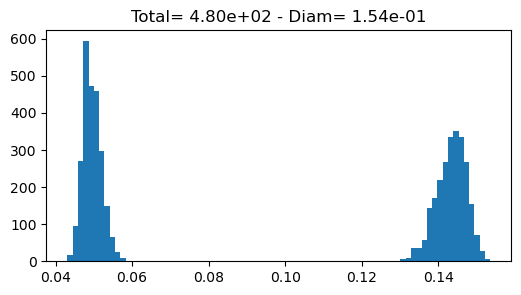

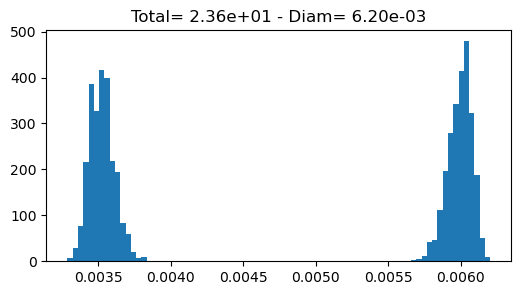

In [24]:
plt.figure(figsize=(6,3))
cos_res = ermet.effective_resistance_matrix(G)[np.triu_indices(G.number_of_nodes(),k=1)].ravel()
plt.hist(cos_res, bins=80)
total=np.sum(cos_res)
diam=np.max(cos_res)
plt.title(f"Total= {total:.2e} - Diam= {diam:.2e}")
plt.show()

plt.figure(figsize=(6,3))
ct_res = squareform(commute_times(G, evl, evc, resistance = True)).ravel()
plt.hist(ct_res, bins=80)
total=np.sum(ct_res)
diam=np.max(ct_res)
plt.title(f"Total= {total:.2e} - Diam= {diam:.2e}")
plt.show()

In [25]:
G.number_of_nodes()*np.sum(1/evl[1:])

479.83105011680937

In [26]:
filtered_cosc_res = ermet.effective_resistance_matrix(G)*A.toarray()
np.sum(filtered_cosc_res[np.triu_indices(G.number_of_nodes(),k=1)]), \
np.sum(ermet.effective_resistance_matrix(G)[np.triu_indices(G.number_of_nodes(),k=1)])

(99.00000000000001, 479.83105011681215)

In [27]:
filtered_ct_res = commute_times(G, evl, evc, resistance = True)*A.toarray()
np.sum(filtered_ct_res[np.triu_indices(G.number_of_nodes(),k=1)]), \
np.sum(commute_times(G, evl, evc, resistance = True)[np.triu_indices(G.number_of_nodes(),k=1)])

(7.025926463507814, 23.617547827945373)

**Plots**

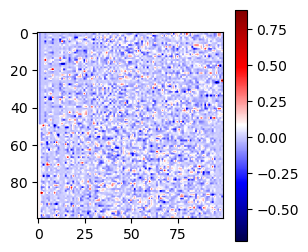

In [28]:
evl, evc = find_evecs(L)
evl = np.real(evl)
evc = np.real(evc)
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(evc, cmap='seismic')
plt.colorbar()
plt.show()

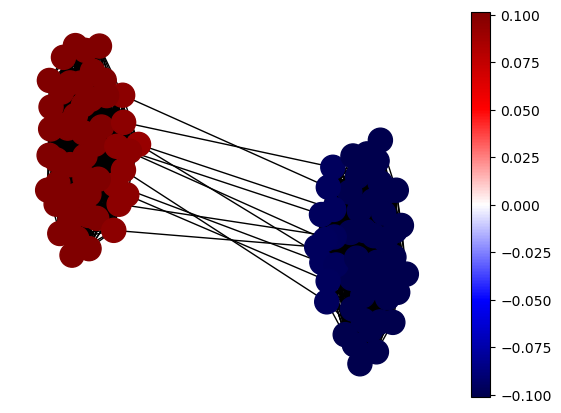

In [29]:
fig, ax = plt.subplots(figsize=(7,5))
plot_eigenvector_over_graph(G, evc, 1, ax)

Get commute times embedding and commute times distances

In [30]:
CTE = commute_times_embedding(G, evl, evc)
CT = commute_times(G, evl, evc)
Res = commute_times(G, evl, evc, resistance = True)
B = ermet.biharmonic(G).round(10)

Plot commute times distances

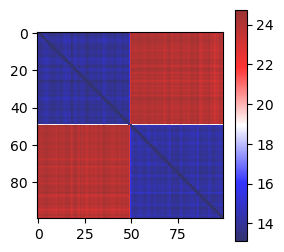

In [31]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(CT, alpha=0.8, cmap="seismic", vmin=squareform(CT).min(), vmax=squareform(CT).max())
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

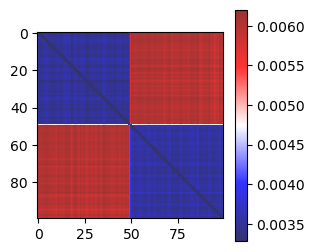

In [32]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(Res, alpha=0.8, cmap="seismic", vmin=squareform(Res).min(), vmax=squareform(Res).max())
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

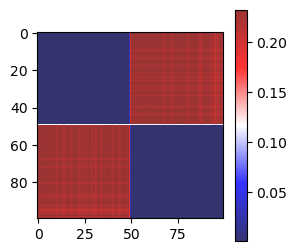

In [33]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(B, alpha=0.8, cmap="seismic", vmin=squareform(B).min(), vmax=squareform(B).max())
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

In [34]:
import matplotlib as mpl

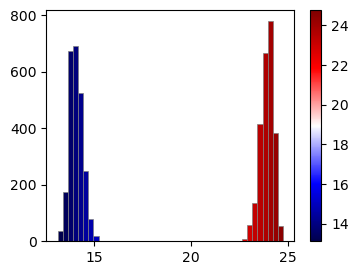

In [35]:
bns = int(np.sqrt(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(4,3))
cm = plt.cm.get_cmap('seismic')
n, bins, patches = plt.hist(squareform(CT), 
                            bins = bns,
                            edgecolor='grey', linewidth=0.5)

norm = mpl.colors.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max())
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cm(norm(c)))
sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max()))
    #sm.set_array([])
cbar = plt.colorbar(sm)

plt.show()

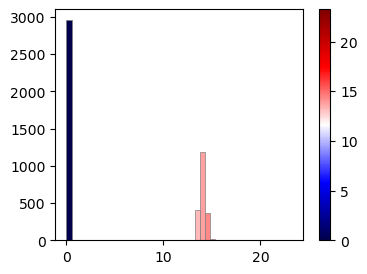

In [36]:
# Filtered distances
bns = int(np.sqrt(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(4,3))
cm = plt.cm.get_cmap('seismic')
n, bins, patches = plt.hist(squareform((CT*A.toarray())), 
                            bins = bns,
                            edgecolor='grey', linewidth=0.5)

norm = mpl.colors.Normalize(vmin=squareform((CT*A.toarray())).min(), vmax=squareform((CT*A.toarray())).max())
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cm(norm(c)))
sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=squareform((CT*A.toarray())).min(), vmax=squareform((CT*A.toarray())).max()))
    #sm.set_array([])
cbar = plt.colorbar(sm)

plt.show()

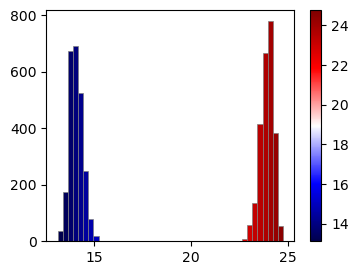

In [37]:
bns = int(np.sqrt(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(4,3))
cm = plt.cm.get_cmap('seismic')
n, bins, patches = plt.hist(squareform(CT), 
                            bins = bns,
                            edgecolor='grey', linewidth=0.5)

norm = mpl.colors.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max())
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cm(norm(c)))
sm = plt.cm.ScalarMappable(cmap="seismic", norm=plt.Normalize(vmin=squareform(CT).min(), vmax=squareform(CT).max()))
    #sm.set_array([])
cbar = plt.colorbar(sm)

plt.show()

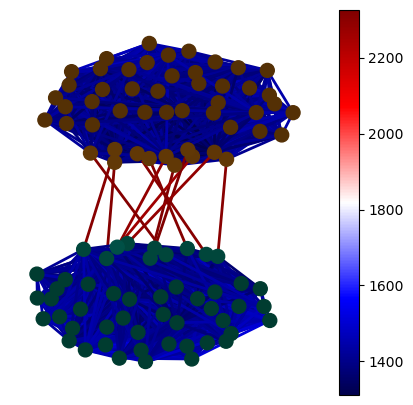

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
opt = {
    "node_color": np.array(evc[:,1]).ravel(),
    "width": 2,
     "cmap": plt.cm.BrBG,
    "edge_cmap": plt.cm.seismic,
    "with_labels": False,
    "node_size": 100,
}
plot_commute_times_over_graph(G, evl, evc, ax, options=opt, CT=None)

Plot Commute Times Embedding

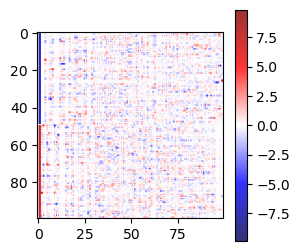

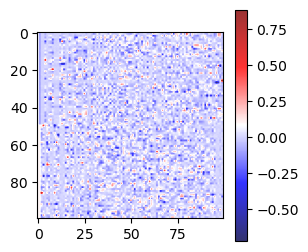

In [39]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(np.transpose(CTE), alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(evc, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

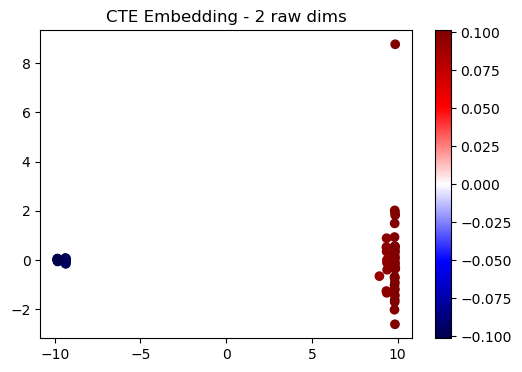

In [40]:
from sklearn.manifold import TSNE
fig, ax = plt.subplots(figsize=(6,4))
CTE_T = np.array(np.transpose(CTE))
im = ax.scatter(CTE_T[:,1], CTE_T[:,2], c=np.array(np.real(evc[:,1])), cmap=plt.cm.seismic)
plt.title("CTE Embedding - 2 raw dims")
fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
im = ax.scatter(np.array(evc[:,1]), np.array(evc[:,2]), c=np.array(np.real(evc[:,1])), cmap=plt.cm.seismic)
plt.title("Eigen Embedding")
fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
eigen_2d = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=3).fit_transform(evc)

fig, ax = plt.subplots(figsize=(6,4))
im = ax.scatter(eigen_2d[:,0], eigen_2d[:,1], c=np.array(np.real(evc[:,1])), cmap=plt.cm.seismic)
plt.title("Eigen Embedding")
fig.colorbar(im, ax=ax)

## Structural Link Predictor by CT

**See GAE:** https://github.com/tkipf/gae/blob/0ebbe9b9a8f496eb12deb9aa6a62e7016b5a5ac3/gae/layers.py#L107

In [ ]:
#Prediction
ZZT = np.array(np.matmul(CTE_T,CTE))
np.fill_diagonal(ZZT,0)

#Identify non-existing links
notA = 1-nx.to_numpy_array(G)
np.fill_diagonal(notA, 0)
notA


plt.imshow(ZZT*notA, cmap=plt.cm.seismic)
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
plt.imshow(CT, alpha=0.8, cmap="seismic")
#plt.imshow(Res, alpha=0.8, cmap="seismic")
plt.colorbar()
plt.show()

# Examples of the proposed metrics

In [42]:
#G = nx.barabasi_albert_graph(100,1)
G = nx.powerlaw_cluster_graph(100, 2, 1)


In [43]:
L = nx.laplacian_matrix(G)
A = nx.adjacency_matrix(G)
evl, evc = find_evecs(L)
evl = np.real(evl)
evc = np.real(evc)
index_to_node = {index: node for index, node in enumerate(G.nodes())}

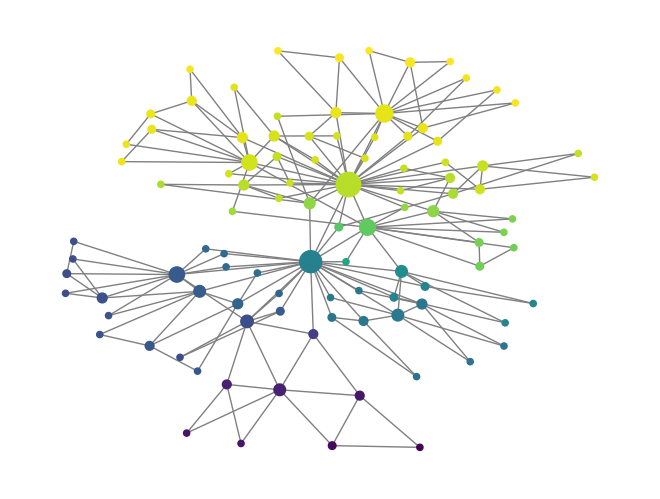

In [44]:
pos = nx.kamada_kawai_layout(G)
options = {
    "node_color": np.array(evc[:,1]).ravel()+10,
    "edge_color": 'grey',
    "width": 1,
    "node_size":np.array([itm[1] for itm in dict(G.degree).items()])*10,
    "edge_cmap": plt.cm.seismic,
    "cmap": plt.cm.viridis,
    "with_labels": False,
}
# Draw the graph
nx.draw(G, pos, **options)

In [45]:
original_res = ermet.effective_resistance_matrix(G)
original_CT = commute_times(G, evl, evc, resistance = True)

In [46]:
G.number_of_nodes()*np.sum(1/evl[1:]), \
np.sum(original_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)])

(6094.211189112453, 6094.211189112447)

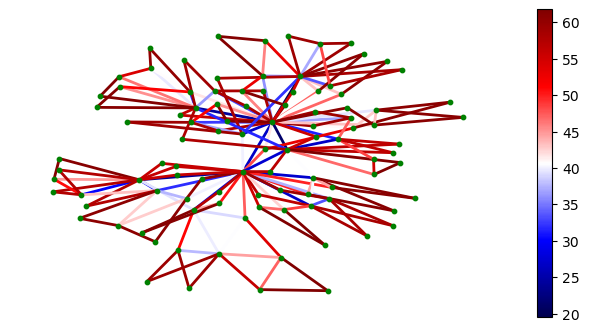

In [47]:
fig, ax = plt.subplots(figsize=(8,4))
opt = {
    "node_color": "green",
    "width": 2,
    "edge_cmap": plt.cm.seismic,
    "with_labels": False,
    "node_size": 10,
}
plot_commute_times_over_graph(G, evl, evc, ax, CT = original_res, options = opt)

In [48]:
def plt_ct_wrt_node(G, idx, CT, cmap='viridis', er_max=None, er_min=None):
    plt.figure(figsize=(9,6))
    nx.draw_networkx_nodes(G, pos=pos, 
                           node_size=40, 
                           nodelist=list(G.nodes),
                           vmin = er_min,
                           vmax = er_max,
                           node_color=CT[idx,:],
                           cmap=cmap,
                           edgecolors=None,
                           label='CT distance')
    nx.draw_networkx_nodes(G, pos=pos, 
                           node_size=100,
                           nodelist=[idx], 
                           node_color='red',
                           edgecolors='black', 
                           node_shape = 'v',
                           label='Source node')
    nx.draw_networkx_edges(G, pos=pos, edge_color='grey')
    plt.legend()
    
    er_min = CT[idx,:].min() if er_min is None else er_min
    er_max = CT[idx,:].max() if er_max is None else er_max
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                            norm=plt.Normalize(vmin=er_min, vmax=er_max))

    cbar = plt.colorbar(sm)
    plt.show()

In [49]:
edge_diameter = np.unravel_index(np.argmax(original_res), shape=original_res.shape)
edge_diameter = (index_to_node[edge_diameter[0]], index_to_node[edge_diameter[1]])
node_source_idx = edge_diameter[0]
node_destiny = edge_diameter[1]
node_source_idx, node_destiny

(63, 84)

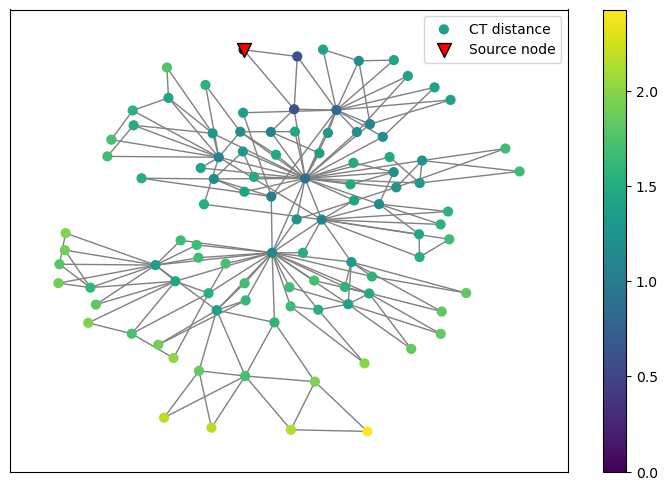

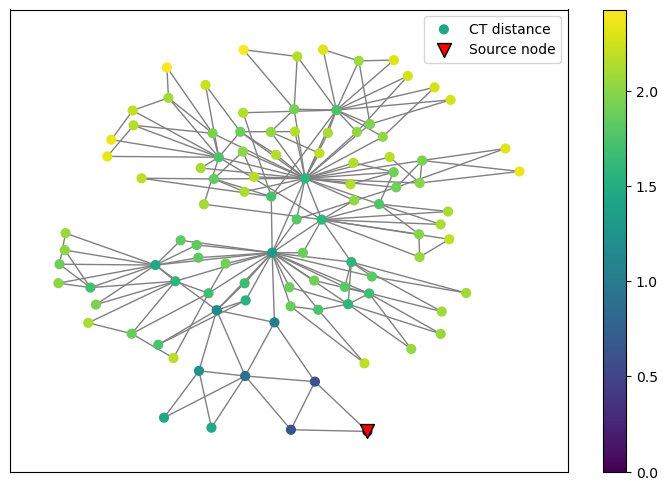

In [50]:
original_res = ermet.effective_resistance_matrix(G)
#original_CT = commute_times(G, evl, evc, resistance = True)
plt_ct_wrt_node(G, node_source_idx, original_res)
#plt_ct_wrt_node(G, node_idx, original_CT)

#Destiny
plt_ct_wrt_node(G, node_destiny, original_res)

In [51]:
G.add_edge(node_source_idx, node_destiny)
node_source_idx, node_destiny

(63, 84)

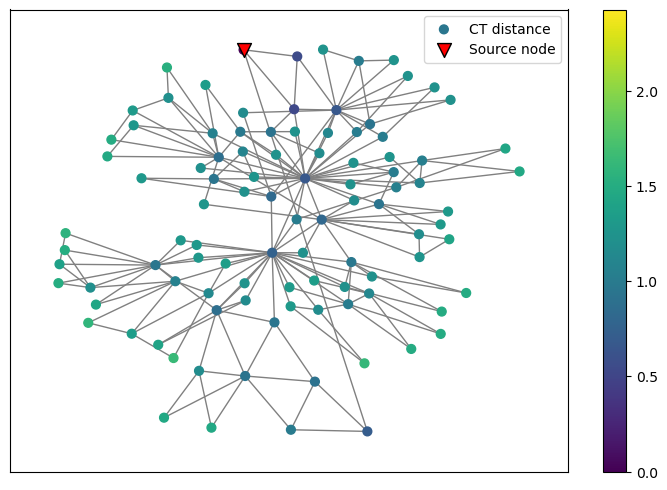

In [52]:
rw_res = ermet.effective_resistance_matrix(G)
plt_ct_wrt_node(G, node_source_idx, rw_res, 
                er_min=original_res[node_source_idx,:].min(),
                er_max=original_res[node_source_idx,:].max())

Let's add the most probable link instead: minimun ER that is not already a link

**Histogram of Nodes distances and node metrics and Graph distances and metrics**

In [53]:
bins = int(np.sqrt(G.number_of_nodes())/2)

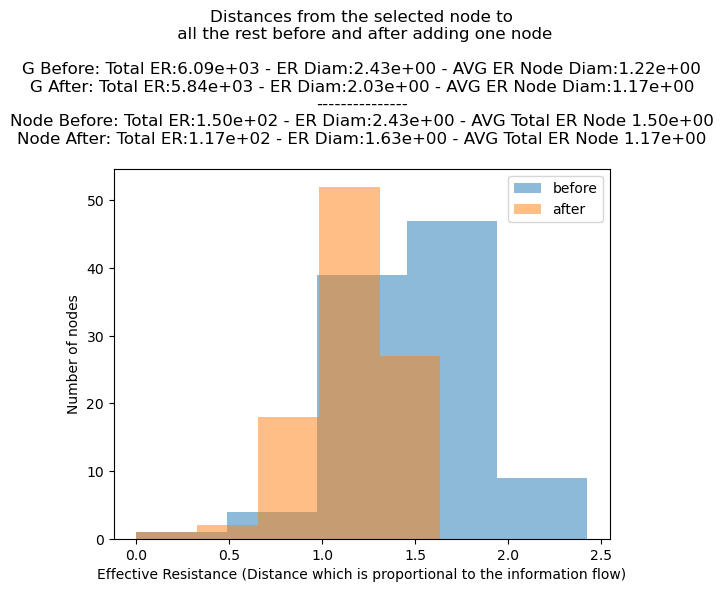

In [54]:
plt.hist(original_res[node_source_idx,:],alpha=0.5,bins=bins, label='before')
plt.hist(rw_res[node_source_idx,:],alpha=0.5,bins=bins, label='after')
plt.legend()

title = "Distances from the selected node to\n all the rest before and after adding one node\n\n"
total = ermet.total_effective_resistance(original_res)
diam = ermet.resistance_diameter(original_res)
avg_diam = ermet.avg_node_mean_er(original_res)
title+=f"G Before: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"

total = ermet.total_effective_resistance(rw_res)
diam = ermet.resistance_diameter(rw_res)
avg_diam = ermet.avg_node_mean_er(rw_res)
title+=f"G After: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"
title+='---------------\n'

total = ermet.node_total_er(original_res)[node_source_idx]
diam = ermet.node_diameters(original_res)[node_source_idx]
avg_total = ermet.node_mean_er(original_res)[node_source_idx]
title+=f"Node Before: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG Total ER Node {avg_total:.2e}\n"

total = ermet.node_total_er(rw_res)[node_source_idx]
diam = ermet.node_diameters(rw_res)[node_source_idx]
avg_total = ermet.node_mean_er(rw_res)[node_source_idx]
title+=f"Node After: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG Total ER Node {avg_total:.2e}\n"

plt.title(title)

plt.xlabel("Effective Resistance (Distance which is proportional to the information flow)")
plt.ylabel("Number of nodes")
plt.show()

In [55]:
bins = int(np.sqrt(G.number_of_edges())/2)

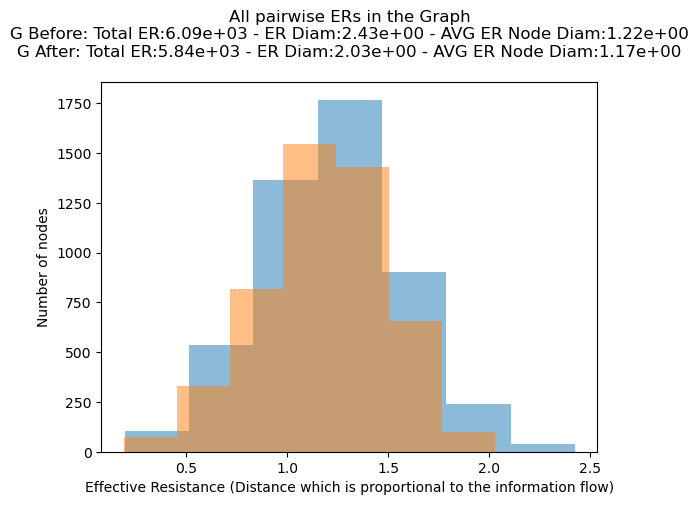

In [56]:
plt.hist(original_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)],alpha=0.5,bins=bins, label='before')
plt.hist(rw_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)],alpha=0.5,bins=bins, label='after')

title = "All pairwise ERs in the Graph\n"

total = ermet.total_effective_resistance(original_res)
diam = ermet.resistance_diameter(original_res)
avg_diam = ermet.avg_node_mean_er(original_res)
title+=f"G Before: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"

total = ermet.total_effective_resistance(rw_res)
diam = ermet.resistance_diameter(rw_res)
avg_diam = ermet.avg_node_mean_er(rw_res)
title+=f"G After: Total ER:{total:.2e} - ER Diam:{diam:.2e} - AVG ER Node Diam:{avg_diam:.2e}\n"


plt.title(title)

plt.xlabel("Effective Resistance (Distance which is proportional to the information flow)")
plt.ylabel("Number of nodes")
plt.show()

In [57]:
bins= int(np.sqrt(G.number_of_nodes()))

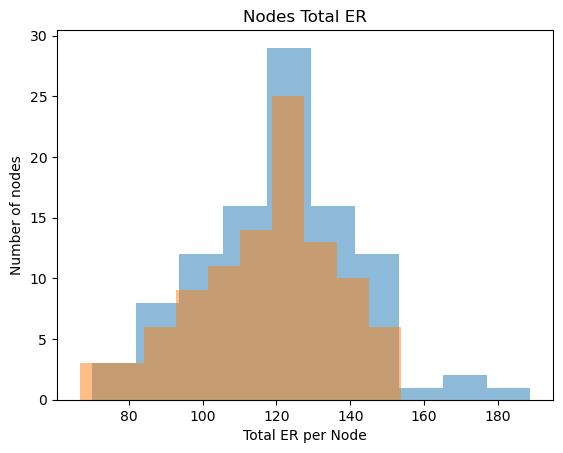

In [58]:
total_ers_bef = ermet.node_total_er(original_res)
total_ers_aft = ermet.node_total_er(rw_res)

plt.hist(total_ers_bef,alpha=0.5,bins=bins, label='before')
plt.hist(total_ers_aft,alpha=0.5,bins=bins, label='after')

title = "Nodes Total ER"

plt.title(title)

plt.xlabel("Total ER per Node")
plt.ylabel("Number of nodes")
plt.show()

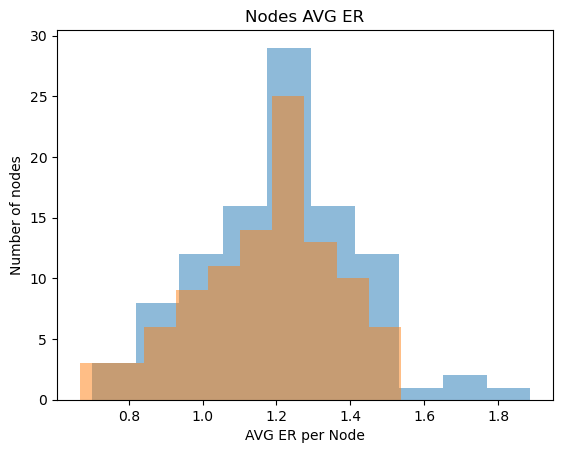

In [59]:
avg_ers_bef = ermet.node_mean_er(original_res)
avg_ers_aft = ermet.node_mean_er(rw_res)

plt.hist(avg_ers_bef,alpha=0.5,bins=bins, label='before')
plt.hist(avg_ers_aft,alpha=0.5,bins=bins, label='after')

title = "Nodes AVG ER"

plt.title(title)

plt.xlabel("AVG ER per Node")
plt.ylabel("Number of nodes")
plt.show()

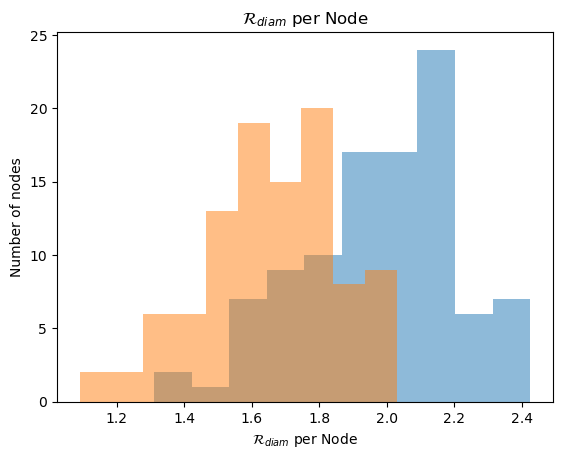

In [60]:
diam_nodes_bef = ermet.node_diameters(original_res)
diam_nodes_aft = ermet.node_diameters(rw_res)

plt.hist(diam_nodes_bef,alpha=0.5,bins=bins, label='before')
plt.hist(diam_nodes_aft,alpha=0.5,bins=bins, label='after')

title = "$\mathcal{R}_{diam}$ per Node"

plt.title(title)

plt.xlabel("$\mathcal{R}_{diam}$ per Node")
plt.ylabel("Number of nodes")
plt.show()

## Discussion

We want to sumarize all the flow on information of the network in a single and consistent measure. However, CT is a distribution of NxN, lets say a joint distribution of edges and y=y. Reducing all the graph to one number implies a loss of information. However, as the community has agreed on doing that, we proposed a new metric that better incorpores the flow of information between groups and it's heavily grounded theoretically. 

In addition, our metric is more powerfull, since it incorpores several pariwise diffusion informations, distribution between groups and so on so forth. Therefore, the knwledge we distilled in this homophily can be used for incorportaing the homophily concept inside this networks. Therefore, the importance of each network in the information flow can be estimated.

* General Graph Statistics
* Add low CT vs High CT: iteration
* Add low CT vs High CT: before and after

## General Graph Statistics

In [61]:
def graph_effective_resistance_metrics(G, pos=None, node_idx=None, filtered=False):
    
    original_res = ermet.effective_resistance_matrix(G)
    evl, evc = find_evecs(nx.laplacian_matrix(G))
    evl = np.real(evl)
    evc = np.real(evc)
    
    if node_idx:
        f, axs = plt.subplots(3,3, figsize=(14,12))
    else:
        f, axs = plt.subplots(2,3, figsize=(16,10))
    
    # Draw the graph
    pos = nx.kamada_kawai_layout(G) if pos is None else pos #spring_layout(G)
    options = {
        "node_color": np.array(evc[:,1]).ravel()+20,
        "edge_color": 'grey',
        "width": 1,
        "node_size":np.array([itm[1] for itm in dict(G.degree).items()])*10,
        "edge_cmap": plt.cm.seismic,
        "cmap": plt.cm.seismic,
        "with_labels": False,
    }
    axs[0][0].set_title('Graph (color=$\lambda_2$, size=$D$)', fontsize=20)
    nx.draw(G, pos, **options, ax=axs[0][0])
    sm = plt.cm.ScalarMappable(cmap=plt.cm.seismic, 
                            norm=plt.Normalize(vmin=np.min(evc[:,1]), vmax=np.max(evc[:,1])))
    plt.colorbar(sm, ax=axs[0][0])
    
    axs[0][0].set_axis_on()
    total = ermet.total_effective_resistance(original_res)
    diam = ermet.resistance_diameter(original_res)
    avg_diam = ermet.avg_node_max_distance(original_res)
    title = f"Graph Metrics: $Res_G$: {total:.2e}\n"
    title += f"$\mathcal{{R}}_{{diam}}$: {diam:.2e}"
    title += f" - $\overline{{\mathcal{{R}}_{{diam}}(V)}}$: {avg_diam:.2e}"
    axs[0][0].set_xlabel(title, fontsize=13)
    
    ######
    ## Node total er as color node over the graph
    f_title = '$Res_G(u)$' if not filtered else '$Res_G(u, \mathcal{N})$'
    axs[0][1].set_title(f_title, fontsize=20)
    nodes_total_er = ermet.node_total_er(original_res, G=G, filtered=filtered)
    options['node_size'] = 100
    options['node_color'] = nodes_total_er
    options["cmap"] = plt.cm.viridis
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(nodes_total_er), vmax=np.max(nodes_total_er)))
    plt.colorbar(sm, ax=axs[0][1])
    axs[0][1].set_xlabel('$Res_G(u)$', fontsize=20)
    nx.draw(G, pos, **options, ax=axs[0][1])
    
    ######
    ## Node diameters as color node over the graph
    axs[0][2].set_title('$\mathcal{R}_{diam}(u)$', fontsize=20)
    nodes_diams = ermet.node_diameters(original_res)
    options['node_color'] = nodes_diams
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(nodes_diams), vmax=np.max(nodes_diams)))
    plt.colorbar(sm, ax=axs[0][2])
    nx.draw(G, pos, **options, ax=axs[0][2])
    
    ######
    ## Tots ER
    bins = int(np.sqrt(G.number_of_edges()))
    axs[1][0].hist(original_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)],alpha=1,bins=bins, color='black')
    title = "All $Res(u,v)$ in the Graph"
    axs[1][0].set_title(title, fontsize=15)
    axs[1][0].set_xlabel("$Res(u,v)$", fontsize=14)
    axs[1][0].set_ylabel("Number of edges", fontsize=12)
    
    
    ######
    ## hist node ER
    bins = int(np.sqrt(G.number_of_nodes()))
    axs[1][1].hist(nodes_total_er,alpha=0.8,bins=bins, color='black')
    axs[1][1].set_title("$Res_G(u)$ for each node", fontsize=15)
    axs[1][1].set_xlabel("$Res_G(u)$", fontsize=14)
    axs[1][1].set_ylabel("Number of nodes", fontsize=12)
    
    
    
    ######
    ## hist diam ER
    axs[1][2].hist(nodes_diams,alpha=1,bins=bins, color='black')
    axs[1][2].axvline(np.mean(nodes_diams), linewidth=2, color='r', label=f"$\overline{{\mathcal{{R}}_{{diam}}(V)}}$")
    title = "$\mathcal{R}_{diam}(u)$ for each node"
    axs[1][2].set_title(title, fontsize=15)
    axs[1][2].set_xlabel("$\mathcal{R}_{diam}(u)$", fontsize=14)
    axs[1][2].set_ylabel("Number of nodes", fontsize=12)
    axs[1][2].legend(fontsize=13)
    
    if node_idx:
        ######
        ## Distances in graph
        nx.draw_networkx_nodes(G, pos=pos, 
                           node_size=40, 
                           nodelist=list(G.nodes),
                           node_color=original_res[node_idx,:],
                           cmap=plt.cm.viridis,
                           edgecolors=None,
                           label='CT distance', ax=axs[2][0])
        
        nx.draw_networkx_nodes(G, pos=pos, 
                               node_size=100,
                               nodelist=[node_idx], 
                               node_color='red',
                               edgecolors='black', 
                               node_shape = 'v',
                               label='Source node', ax=axs[2][0])
        
        nx.draw_networkx_edges(G, pos=pos, edge_color='grey', ax=axs[2][0])
        axs[2][0].legend()
        
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(original_res[node_idx,:]), vmax=np.max(original_res[node_idx,:])))
        plt.colorbar(sm, ax=axs[2][0])
        axs[2][0].set_axis_off()
        
        ######
        ## node histogram distances
        axs[1][0].hist(original_res[node_idx,:],alpha=1,bins=int(np.sqrt(G.number_of_edges())), label=f"node {node_idx}")
        axs[1][0].legend()
        axs[2][1].hist(original_res[node_idx,:],alpha=1,bins=bins, color='black')
        axs[2][1].set_title(f"$Res(u,v)$ for u={node_idx}", fontsize=15)
        axs[2][1].set_xlabel("$Res(u,v)$", fontsize=14)
        axs[2][1].set_ylabel("Number of nodes", fontsize=12)
        

        ######
        ## node metrics
        total_node = ermet.node_total_er(original_res)[node_idx]
        diam_node = ermet.node_diameters(original_res)[node_idx]
        text =  f"Graph Metrics:\n$Res_G$: {total:.2e}\n"
        text += f"$\mathcal{{R}}_{{diam}}$: {diam:.2e}\n"
        text += f"$\overline{{\mathcal{{R}}_{{diam}}(V)}}$: {avg_diam:.2e}"
        text += "\n\n\n"
        text += f"Node Metrics:\n$Res_G(u)$: {total_node:.2e}\n"
        text += f"$\mathcal{{R}}_{{diam}}(u)$: {diam_node:.2e}"
        axs[2, 2].set_axis_off()
        axs[2, 2].text(0, 0, text, fontsize=13)
        
    
    
    #f.suptitle("Graph Metrics")
    
    f.tight_layout()
    plt.show()

In [62]:
def graph_summary_metrics(G, pos=None):
    
    original_res = ermet.effective_resistance_matrix(G)
    print(ermet.total_effective_resistance(original_res))
    evl, evc = find_evecs(nx.laplacian_matrix(G))
    evl = np.real(evl)
    evc = np.real(evc)
        
    MOSAIC="""
    ..00..
    112233
    444555
    666777
    """
    f,axs_dict = plt.subplot_mosaic(MOSAIC, figsize=(12,14),
                                    gridspec_kw={'height_ratios': [1, 1.2, 1, 1]})
    axs = f.get_axes()
    
    # Draw the graph
    pos = nx.kamada_kawai_layout(G) if pos is None else pos #spring_layout(G)
    options = {
        "node_color": np.array(evc[:,1]).ravel()+20,
        "edge_color": 'grey',
        "width": 0.8,
        "node_size":np.array([itm[1] for itm in dict(G.degree).items()])*5,
        "edge_cmap": plt.cm.seismic,
        "cmap": plt.cm.seismic,
        "with_labels": False,
    }
    axs[0].set_title('Graph (color=$\lambda_2$, size=$D$)', fontsize=20)
    nx.draw(G, pos, **options, ax=axs[0])
    sm = plt.cm.ScalarMappable(cmap=plt.cm.seismic, 
                            norm=plt.Normalize(vmin=np.min(evc[:,1]), vmax=np.max(evc[:,1])))
    plt.colorbar(sm, ax=axs[0])
    
    axs[0].set_axis_on()
    total = ermet.total_effective_resistance(original_res)
    diam = ermet.resistance_diameter(original_res)
    avg_diam = ermet.avg_node_max_distance(original_res)
    title = f"Graph Metrics: $Res_G$: {total:.2e} -- "
    title += f"$\mathcal{{R}}_{{diam}}$: {diam:.2e}"
    title += f" -- $\overline{{\mathcal{{R}}_{{diam}}(V)}}$: {avg_diam:.2e}"
    axs[0].set_xlabel(title, fontsize=13)
    
    ######
    ## Node total er as color node over the graph
    f_title = '$Res_G(u)$'
    axs[1].set_title(f_title, fontsize=20)
    nodes_total_er = ermet.node_total_er(original_res)
    options['node_size'] = 100
    options['node_color'] = nodes_total_er
    options["cmap"] = plt.cm.viridis
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(nodes_total_er), vmax=np.max(nodes_total_er)))
    cbar = plt.colorbar(sm, ax=axs[1])
    cbar.ax.tick_params(labelsize=14)
    cbar.outline.set_linewidth(0)
    axs[1].set_xlabel('$Res_G(u)$', fontsize=20)
    nx.draw(G, pos, **options, ax=axs[1])
    
    ######
    ## Node betweeness
    axs[2].set_title('$Res_G(u, \mathcal{N})$', fontsize=20)
    nodes_betwn = ermet.node_total_er(original_res, G=G, filtered=True)
    options['node_color'] = nodes_betwn
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(nodes_betwn), vmax=np.max(nodes_betwn)))
    cbar = plt.colorbar(sm, ax=axs[2])
    cbar.ax.tick_params(labelsize=14)
    cbar.outline.set_linewidth(0)
    nx.draw(G, pos, **options, ax=axs[2])
    
    ######
    ## Node diameters as color node over the graph
    axs[3].set_title('$\mathcal{R}_{diam}(u)$', fontsize=20)
    nodes_diams = ermet.node_diameters(original_res)
    options['node_color'] = nodes_diams
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(nodes_diams), vmax=np.max(nodes_diams)))
    cbar = plt.colorbar(sm, ax=axs[3])
    nx.draw(G, pos, **options, ax=axs[3])
    # Set the tick font size of the colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.outline.set_linewidth(0)
    
    ######
    ## Tots ER
    bins = int(np.sqrt(G.number_of_edges()))
    axs[4].hist(original_res[np.triu_indices(np.sum(G.number_of_nodes()),k=1)],alpha=1,bins=bins, color='black')
    title = "All $Res(u,v)$ in the Graph"
    axs[4].set_title(title, fontsize=15)
    axs[4].set_xlabel("$Res(u,v)$", fontsize=14)
    axs[4].set_ylabel("Number of edges", fontsize=12)
    
    
    ######
    ## hist node ER
    bins = int(np.sqrt(G.number_of_nodes()))
    axs[5].hist(nodes_total_er,alpha=0.8,bins=bins, color='black')
    axs[5].set_title("$Res_G(u)$", fontsize=15)
    axs[5].set_xlabel("$Res_G(u)$", fontsize=14)
    axs[5].set_ylabel("Number of nodes", fontsize=12)
    
    
    
    ######
    ## hist diam ER
    axs[6].hist(nodes_betwn,alpha=1,bins=bins, color='black')
    title = "$Res_G(u, \mathcal{N})$"
    axs[6].set_title(title, fontsize=15)
    axs[6].set_xlabel("$\mathcal{R}_{diam}(u)$", fontsize=14)
    axs[6].set_ylabel("Number of nodes", fontsize=12)
    
    ######
    ## hist diam ER
    axs[7].hist(nodes_diams,alpha=1,bins=bins, color='black')
    axs[7].axvline(np.mean(nodes_diams), linewidth=2, color='r', label=f"$\overline{{\mathcal{{R}}_{{diam}}(V)}}$")
    title = "$\mathcal{R}_{diam}(u)$"
    axs[7].set_title(title, fontsize=15)
    axs[7].set_xlabel("$\mathcal{R}_{diam}(u)$", fontsize=14)
    axs[7].set_ylabel("Number of nodes", fontsize=12)
    axs[7].legend(fontsize=13)
    
    
    #f.suptitle("Graph Metrics")
    
    f.tight_layout()
    plt.show()

In [63]:
sizes = [50, 50]
gap_prob = 0.01
intra_prob_c1 = 0.5
intra_prob_c2 = 0.5
probs = [[intra_prob_c1, gap_prob], [gap_prob, intra_prob_c2]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

In [64]:
sizes = [90, 10]
gap_prob = 0.01
intra_prob_c1 = 0.5
intra_prob_c2 = 0.9
probs = [[intra_prob_c1, gap_prob], [gap_prob, intra_prob_c2]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

In [65]:
sizes = [90, 90, 30]
c1 = 0.7
c2 = 0.7
c3 = 0.9 
c1_c2 = 0.02
c1_c3 = 0.001
c2_c3 = 0.001
probs = [[c1, c1_c2, c1_c3],
         [c1_c2, c2, c2_c3],
         [c1_c3, c2_c3, c3]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

In [66]:
sizes = [90, 90, 50, 15]
c1 = 0.6
c2 = 0.6
c3 = 0.8 
c4 = 0.95 
c1_c2 = 0.03
c1_c3 = 0.01
c2_c3 = 0.01
c1_c4 = 0.001
c2_c4 = 0.001
c3_c4 = 0.001

probs = [[c1, c1_c2, c1_c3, c1_c4],
         [c1_c2, c2, c2_c3, c2_c4],
         [c1_c3, c2_c3, c3, c3_c4],
         [c1_c4, c2_c4, c3_c4, c4]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)

Show metrics

2128.3507913648823


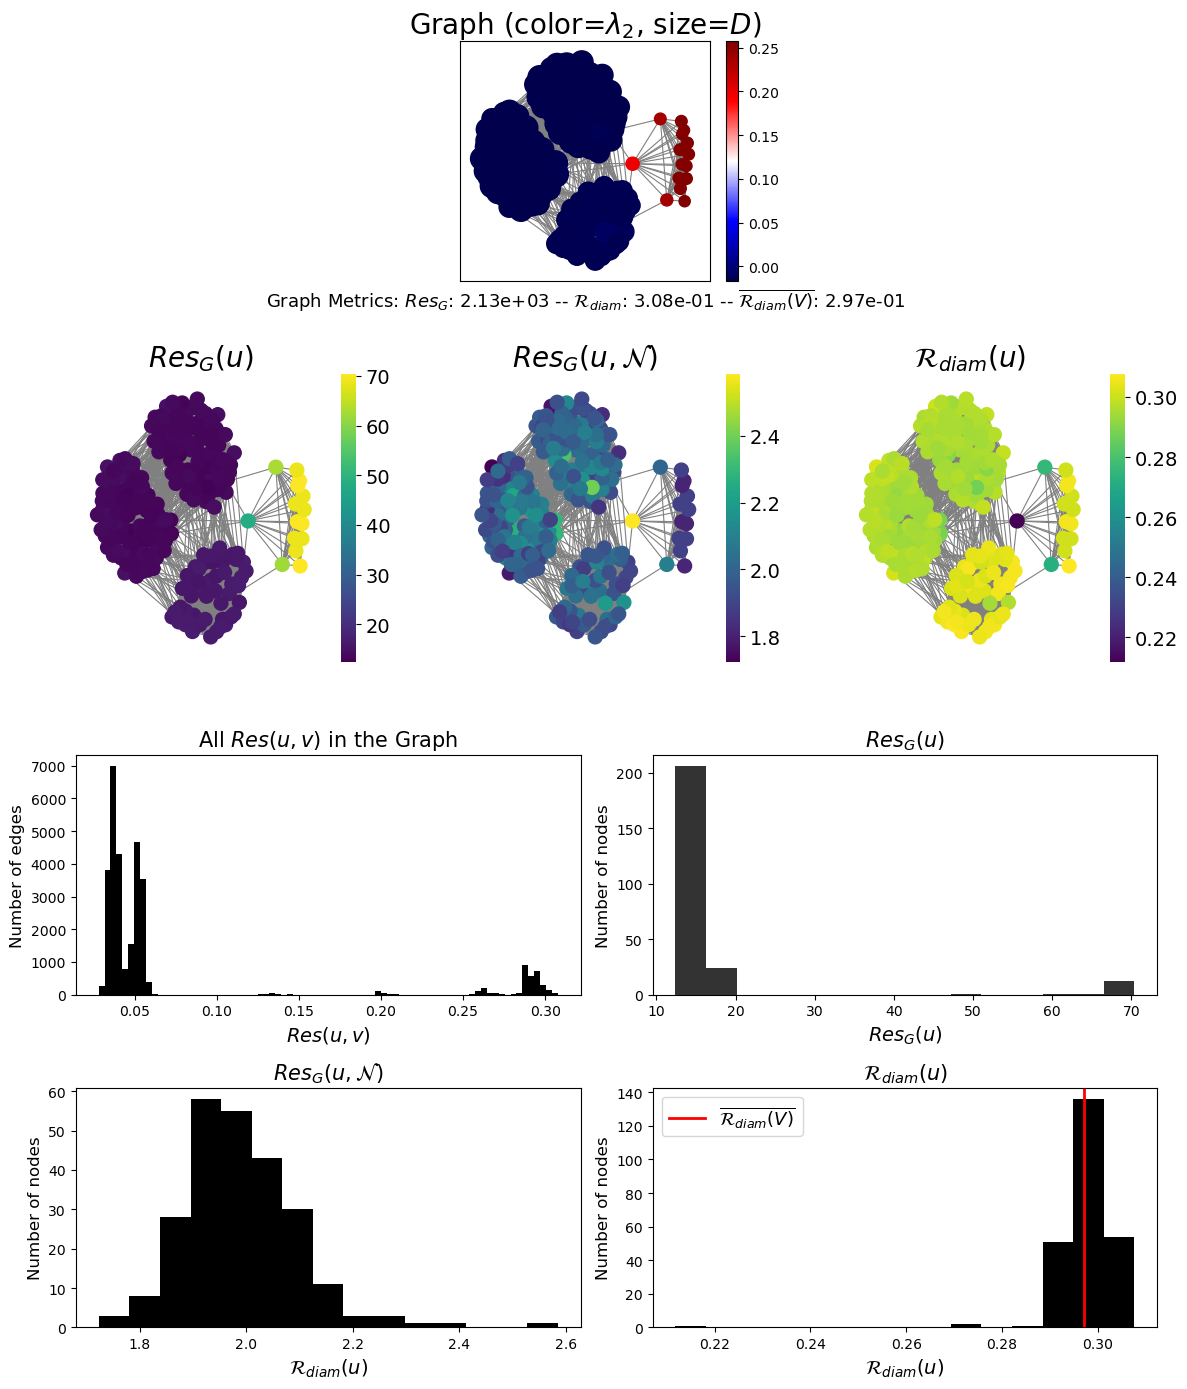

In [67]:
graph_summary_metrics(G)

## Adding edges

In [68]:
def remove_edges_dynamic(G, number_of_edges, ratio=1, rand = False):
    
    strong_data = {"total":[],"diam":[], "diam_filtered":[], "avg_node_diameter":[]}
    rand_data = {"total":[],"diam":[], "diam_filtered":[], "avg_node_diameter":[]}
    weak_data = {"total":[],"diam":[], "diam_filtered":[], "avg_node_diameter":[]}
    
    G_strong = G.copy()
    index_to_node_strong = {index: node for index, node in enumerate(G_strong.nodes())}
    G_rand = G.copy()
    index_to_node_random = {index: node for index, node in enumerate(G_rand.nodes())}
    G_weak = G.copy()
    index_to_node_weak = {index: node for index, node in enumerate(G_weak.nodes())}
        
    for i in tqdm(range(number_of_edges+1)):
        cos_res_strong = ermet.effective_resistance_matrix(G_strong)
        total= ermet.total_effective_resistance(cos_res_strong)
        diam = ermet.resistance_diameter(cos_res_strong)
        diam_f = ermet.resistance_diameter(cos_res_strong, G_strong, filtered=False)
        diam_avg = ermet.avg_node_max_distance(cos_res_strong)
        #save data
        strong_data["total"].append(total) 
        strong_data["diam"].append(diam)
        strong_data["diam_filtered"].append(diam_f)
        strong_data["avg_node_diameter"].append(diam_avg)
        
        if rand:
            cos_res_rand = ermet.effective_resistance_matrix(G_rand)
            total= ermet.total_effective_resistance(cos_res_rand)
            diam = ermet.resistance_diameter(cos_res_rand)
            diam_f = ermet.resistance_diameter(cos_res_rand, G_rand, filtered=False)
            diam_avg = ermet.avg_node_max_distance(cos_res_rand)
            #save data
            rand_data["total"].append(total) 
            rand_data["diam"].append(diam)
            rand_data["diam_filtered"].append(diam_f)
            rand_data["avg_node_diameter"].append(diam_avg)
        
        if i % ratio == 0:
            cos_res_weak = ermet.effective_resistance_matrix(G_weak)
            total= ermet.total_effective_resistance(cos_res_weak)
            diam = ermet.resistance_diameter(cos_res_weak)
            diam_f= ermet.resistance_diameter(cos_res_weak, G_weak, filtered=True)
            diam_avg = ermet.avg_node_max_distance(cos_res_weak)
            #save data
            weak_data["total"].append(total) 
            weak_data["diam"].append(diam)
            weak_data["diam_filtered"].append(diam_f)
            weak_data["avg_node_diameter"].append(diam_avg)
        
        
        #add strong link
        G_strong = rew.add_strong_link(G_strong, cos_res_strong)
        if rand:
            G_rand = rew.add_rand_link(G_rand, cos_res_rand)
        if i % ratio == 0:
            G_weak = rew.add_weak_link(G_weak, cos_res_weak)
        
        
    if rand:
        return G_strong, G_weak, G_rand, strong_data, weak_data, rand_data
    else:
        return G_strong, G_weak, strong_data, weak_data

    
    return G_strong, G_weak, G_rand, strong_data, weak_data, rand_data

In [69]:
number_of_added_links = 15
G1, G2, G3, intra_data, inter_data, rand_data = remove_edges_dynamic(G, number_of_added_links, ratio=1, rand=True)
G.number_of_edges(), G1.number_of_edges(), G2.number_of_edges(), G3.number_of_edges()

  0%|          | 0/16 [00:00<?, ?it/s]

(6208, 6224, 6224, 6224)

Show statistics

In [ ]:
pos = nx.kamada_kawai_layout(G)

In [70]:
G1_diff_edges = list(G.edges() ^ G1.edges())
G2_diff_edges = list(G.edges() ^ G2.edges())
G3_diff_edges = list(G.edges() ^ G3.edges())

In [71]:
G.number_of_nodes(), G.number_of_edges(), G2.number_of_edges()

(245, 6208, 6224)

In [72]:
def compare_graphs(graph_list, graph_names=None, pos=None, edge_highlight=False, node_size=5, save=False):
    
    ori_G = graph_list[0]
    original_res = ermet.effective_resistance_matrix(ori_G)
    ori_total = ermet.total_effective_resistance(original_res)
    ori_diam = ermet.resistance_diameter(original_res)
    ori_avg_diam = ermet.avg_node_max_distance(original_res)
    ori_nodes_total_er = ermet.node_total_er(original_res)
    ori_nodes_betwn = ermet.node_total_er(original_res, G=ori_G, filtered=True)
    ori_nodes_diams = ermet.node_diameters(original_res)
    #evl, evc = find_evecs(nx.laplacian_matrix(G))
    #evl = np.real(evl)
    #evc = np.real(evc)
    
    """MOSAIC=''
    for i in range(len(graph_list)):
        j, k, l, m = chr(i*4+97), chr(i*4+98), chr(i*4+99), chr(i*4+100)
        MOSAIC += f"{j}{k}{l}{m}\n"
    f,axs_dict = plt.subplot_mosaic(MOSAIC,
                                    figsize=(14,4*len(graph_list)),
                                    gridspec_kw={'width_ratios': [.5, 1, 1, 1]})"""
    f, axs = plt.subplots(len(graph_list),4, 
                          figsize=(14,4*len(graph_list)),
                         gridspec_kw={'width_ratios': [.4, 1, 1, 1]})
    
    # Draw the graph
    pos = nx.kamada_kawai_layout(ori_G) if pos is None else pos #spring_layout(G)
    options = {
        "edge_color": 'grey',
        "width": 0.8,
        "node_size":np.array([itm[1] for itm in dict(ori_G.degree).items()])*node_size,
        "edge_cmap": plt.cm.seismic,
        "cmap": plt.cm.seismic,
        "with_labels": False,
    }
    
    axs[0][1].set_title("$Res_G(u)$", fontsize=16)
    axs[0][2].set_title('\n'+'$Res_G(u, \mathcal{N})$', fontsize=16)
    axs[0][3].set_title('$\mathcal{R}_{diam}(u)$', fontsize=16)
    

    for idx, G in enumerate(graph_list):
        
        resistance = ermet.effective_resistance_matrix(G)
        
        total = ermet.total_effective_resistance(resistance)
        diam = ermet.resistance_diameter(resistance)
        avg_diam = ermet.avg_node_max_distance(resistance)
        
        suptitle = f"\n\n$Res_G$: {total:.2e}\n"
        suptitle += f"$\mathcal{{R}}_{{diam}}$: {diam:.2e}\n"
        suptitle += f"$\overline{{\mathcal{{R}}_{{diam}}(V)}}$: {avg_diam:.2e}"
        axs[idx][0].axis('off')
        axs[idx][0].text(1, 1, f'{graph_names[idx]}', ha='right', va='top', fontsize=14)
        axs[idx][0].text(1, 1, suptitle, ha='right', va='top', fontsize=12)

        ######
        ## Node total er as color node over the graph
        nodes_total_er = ermet.node_total_er(resistance)
        
        #f_title = '$Res_G(u)$'
        #axs[idx][1].set_title(f_title, fontsize=14)
        options['node_color'] = nodes_total_er
        options["cmap"] = plt.cm.viridis
        nx.draw(G, pos, **options, ax=axs[idx][1],
                vmin =ori_nodes_total_er.min() , vmax=ori_nodes_total_er.max())        

        ######
        ## Node diameters as color node over the graph
        nodes_betwn = ermet.node_total_er(resistance, G=G, filtered=True)
        
        #axs[idx*4+2].set_title('\n'+'$Res_G(u, \mathcal{N})$', fontsize=14)
        options['node_color'] = nodes_betwn
        nx.draw(G, pos, **options, ax=axs[idx][2],
                vmin =ori_nodes_betwn.min() , vmax=ori_nodes_betwn.max())

        ######
        ## Node diameters as color node over the graph
        nodes_diams = ermet.node_diameters(resistance)
        #axs[idx*4+3].set_title('$\mathcal{R}_{diam}(u)$', fontsize=14)
        options['node_color'] = nodes_diams
        nx.draw(G, pos, **options, ax=axs[idx][3],
                vmin =ori_nodes_diams.min() , vmax=ori_nodes_diams.max())
        
        
        if edge_highlight:
            G_diff_edges = list(ori_G.edges() ^ G.edges())
            nx.draw_networkx_edges(G, edgelist = G_diff_edges,
                                   pos=pos, edge_color='orange', ax = axs[idx][1])
            nx.draw_networkx_edges(G, edgelist = G_diff_edges,
                                   pos=pos, edge_color='orange', ax = axs[idx][2])
            nx.draw_networkx_edges(G, edgelist = G_diff_edges,
                                   pos=pos, edge_color='orange', ax = axs[idx][3])
            
    
    ### COLORBARS
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                norm=plt.Normalize(vmin=np.min(ori_nodes_total_er), 
                                                   vmax=np.max(ori_nodes_total_er)))
    cbar = plt.colorbar(sm, ax=axs[:,1], shrink=0.5)
    cbar.ax.tick_params(labelsize=12)
    cbar.outline.set_linewidth(0)
        
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                norm=plt.Normalize(vmin=np.min(ori_nodes_betwn), 
                                                   vmax=np.max(ori_nodes_betwn)))
    cbar = plt.colorbar(sm, ax=axs[:, 2], shrink=0.5)
    cbar.ax.tick_params(labelsize=12)
    cbar.outline.set_linewidth(0)
            
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                norm=plt.Normalize(vmin=np.min(ori_nodes_diams), 
                                                   vmax=np.max(ori_nodes_diams)))
    cbar = f.colorbar(sm, ax=axs[:, 3], format='%.1f', shrink=0.5) #axs[idx*4+3]
    cbar.ax.tick_params(labelsize=12, labelleft=True, labelright=False, left=True, right=False)
    cbar.outline.set_linewidth(0)
    
    
    #plt.subplots_adjust(wspace=-0.1)
    #f.tight_layout()
    if save:
        f.savefig('nodemetricsexample.pdf', dpi=300, bbox_inches='tight')
    plt.show()

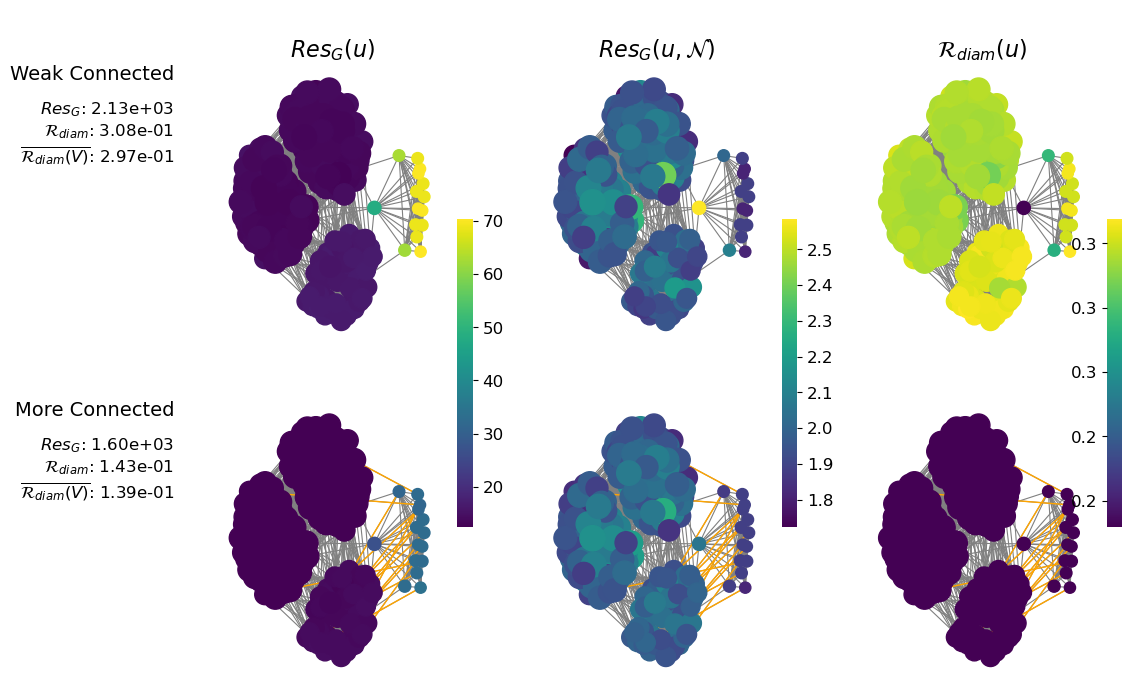

In [73]:
compare_graphs([G, G2],
               graph_names=['Weak Connected', 'More Connected'], 
              edge_highlight=True,
              save=False)

Print 4 versions of the graph. new links as orange

In [77]:
pos = nx.kamada_kawai_layout(G)

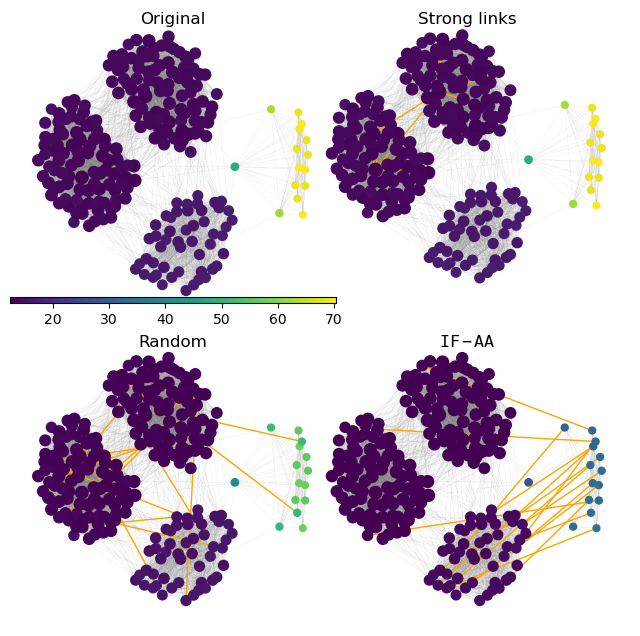

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

A= nx.adjacency_matrix(G)
f, axs = plt.subplots(2,2, figsize=(8,8))
options = {
    "edge_color": 'grey',
    "width": 0.05,
    "edge_cmap": plt.cm.seismic,
    "cmap": plt.cm.viridis,
    "with_labels": False,
}

axs = axs.ravel()
aux=10

ori_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G))
strong_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G1))
weak_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G2))
rand_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G3))

#ori_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G), G, filtered=True)
#strong_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G1), G1, filtered=True)
#weak_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G2), G2, filtered=True)
#rand_cos_res = ermet.node_total_er(ermet.effective_resistance_matrix(G3), G3, filtered=True)

#ori_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G))
#strong_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G1))
#weak_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G2))
#rand_cos_res = ermet.node_diameters(ermet.effective_resistance_matrix(G3))

axs[0].set_title("Original", pad=-10)
nx.draw(G, pos, ax = axs[0], **options,
       node_size = [d+aux for n,d in G.degree()],
       node_color=ori_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())

axs[1].set_title("Strong links", pad=-10)
nx.draw(G1, pos, ax = axs[1], **options,
        node_size = [d+aux for n,d in G1.degree()],
       node_color=strong_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())
nx.draw_networkx_edges(G1, edgelist = G1_diff_edges, pos=pos, edge_color='orange', ax = axs[1])

axs[2].set_title("Random", pad=-10)
nx.draw(G3, pos, ax = axs[2], **options,
        node_size = [d+aux for n,d in G3.degree()],
       node_color=rand_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())
nx.draw_networkx_edges(G3, edgelist = G3_diff_edges, pos=pos, edge_color='orange', ax = axs[2])

axs[3].set_title("$\mathtt{IF-AA}$", pad=-10)
nx.draw(G2, pos, ax = axs[3], **options,
        node_size = [d+aux for n,d in G2.degree()],
       node_color=weak_cos_res,
       vmin =ori_cos_res.min() , vmax=ori_cos_res.max())
nx.draw_networkx_edges(G2, edgelist = G2_diff_edges, pos=pos, edge_color='orange', ax = axs[3])


plt.subplots_adjust(wspace=-0.1, hspace=0.1)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                            norm=plt.Normalize(vmin=np.min(ori_cos_res), vmax=np.max(ori_cos_res)))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("bottom", size="2%", pad = -0.2)
plt.colorbar(sm, cax=cax, orientation='horizontal')
#plt.tight_layout()
#f.savefig('RewiredVersion.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [79]:
int(np.ceil(9/2))

5

Print rate of decreasing

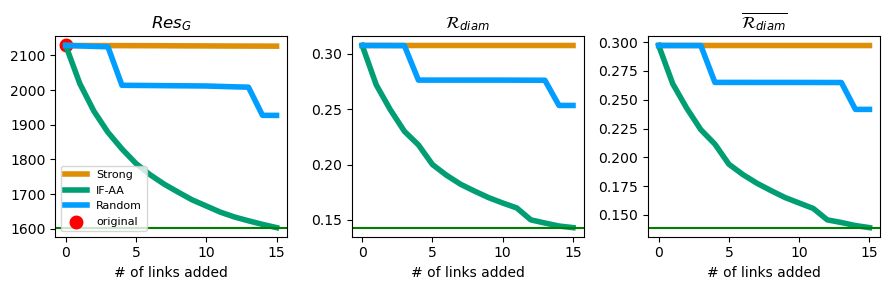

In [80]:
f, axs = plt.subplots(1,3, figsize=(9,3))

orange = (222/255,143/255,5/255)
green = (2/255,158/255,115/255)
blue = (2/255,158/255,255/255)

axs[0].set_title('$Res_G$')
axs[0].set_xlabel('# of links added')
axs[0].plot(intra_data['total'], label='Strong', linewidth=4, color=orange)
axs[0].plot(inter_data['total'], label='IF-AA', linewidth=4, color=green)
axs[0].plot(rand_data['total'], label='Random', linewidth=4, color=blue)
axs[0].scatter(0, np.max(intra_data['total']), label='original', linewidth=4, color='r')
axs[0].legend(fontsize=8)
axs[0].axhline(np.min([np.min(intra_data['total']),np.min(inter_data['total'])]),\
                 color='green')

axs[1].set_title('$\mathcal{R}_{diam}$')
axs[1].set_xlabel('# of links added')
axs[1].plot(intra_data['diam'], label='intra', linewidth=4, color=orange)
axs[1].plot(inter_data['diam'], label='inter', linewidth=4, color=green)
axs[1].plot(rand_data['diam'], label='rand', linewidth=4, color=blue)
axs[1].axhline(np.min([np.min(intra_data['diam']),np.min(inter_data['diam'])]),\
                 color='green')


axs[2].set_title('$\overline{\mathcal{R}_{diam}}$')
axs[2].set_xlabel('# of links added')
axs[2].plot(intra_data['avg_node_diameter'], label='intra', linewidth=4, color=orange)
axs[2].plot(inter_data['avg_node_diameter'], label='inter', linewidth=4, color=green)
axs[2].plot(rand_data['avg_node_diameter'], label='rand', linewidth=4, color=blue)
axs[2].axhline(np.min([np.min(intra_data['avg_node_diameter']),np.min(inter_data['avg_node_diameter'])]),\
                 color='green')


#plt.suptitle('Difference adding Weak and Strong Ties', fontsize=14)
plt.tight_layout()
plt.show()

Print violinplots

In [81]:
ori_cos_res = ermet.effective_resistance_matrix(G)
strong_cos_res = ermet.effective_resistance_matrix(G1)
weak_cos_res = ermet.effective_resistance_matrix(G2)
rand_cos_res = ermet.effective_resistance_matrix(G3)
all_res = [squareform(ori_cos_res.round(5)),
           squareform(strong_cos_res.round(5)),
           squareform(weak_cos_res.round(5)),
           squareform(rand_cos_res.round(5))]

ori_node_total_res = ermet.node_total_er(ori_cos_res)
strong_node_total_res = ermet.node_total_er(strong_cos_res)
weak_node_total_res = ermet.node_total_er(weak_cos_res)
rand_node_total_res = ermet.node_total_er(rand_cos_res)
all_total_res = [ori_node_total_res, strong_node_total_res,
                 weak_node_total_res, rand_node_total_res]

ori_node_total_filtered_res = ermet.node_total_er(ori_cos_res, G, filtered=True)
strong_node_total_filtered_res = ermet.node_total_er(strong_cos_res, G1, filtered=True)
weak_node_total_filtered_res = ermet.node_total_er(weak_cos_res, G2, filtered=True)
rand_node_total_filtered_res = ermet.node_total_er(rand_cos_res, G3, filtered=True)
all_filtered_res = [ori_node_total_filtered_res, strong_node_total_filtered_res,
                   weak_node_total_filtered_res, rand_node_total_filtered_res]

ori_diam_total_res = ermet.node_diameters(ori_cos_res)
strong_diam_total_res = ermet.node_diameters(strong_cos_res)
weak_diam_total_res = ermet.node_diameters(weak_cos_res)
rand_diam_total_res = ermet.node_diameters(rand_cos_res)
all_diam_res = [ori_diam_total_res, strong_diam_total_res,
               weak_diam_total_res, rand_diam_total_res]


In [82]:
import seaborn as sns
import pandas as pd

In [83]:
df_res = pd.DataFrame(all_res).transpose()
df_res.columns = ['Original', 'Strong', 'IF-AA', 'Random']

df_diam = pd.DataFrame(all_diam_res).transpose()
df_diam.columns = ['Original', 'Strong', 'IF-AA', 'Random']

df_total = pd.DataFrame(all_total_res).transpose()
df_total.columns = ['Original', 'Strong', 'IF-AA', 'Random']

df_tot_filter = pd.DataFrame(all_filtered_res).transpose()
df_tot_filter.columns = ['Original', 'Strong', 'IF-AA', 'Random']

df_diam = pd.DataFrame(all_diam_res).transpose()
df_diam.columns = ['Original', 'Strong', 'IF-AA', 'Random']

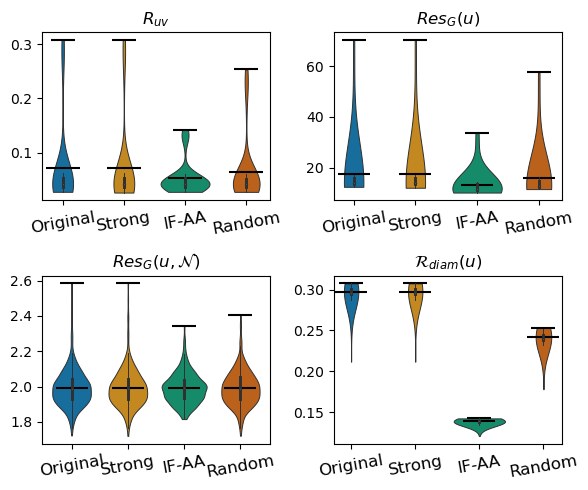

In [84]:
vis.plot_violins_node_metrics(df_res, df_total, df_tot_filter, df_diam)

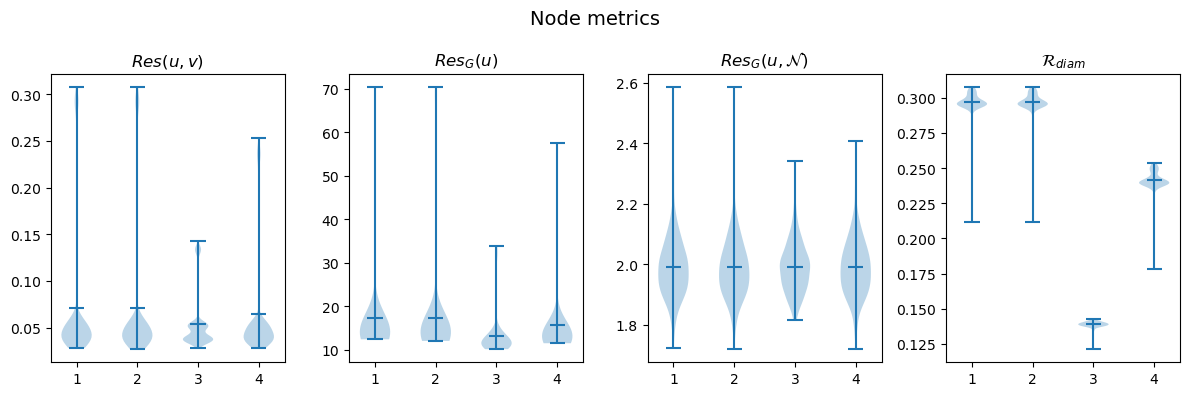

In [85]:
f, axs = plt.subplots(1,4, figsize=(12,4))

axs[0].set_title('$Res(u,v)$')
axs[0].violinplot(all_res, showmeans = True)

axs[1].set_title('$Res_G(u)$')
axs[1].violinplot(all_total_res, showmeans = True)

axs[2].set_title('$Res_G(u, \mathcal{N})$')
axs[2].violinplot(all_filtered_res, showmeans = True)

axs[3].set_title('$\mathcal{R}_{diam}$')
axs[3].violinplot(all_diam_res, showmeans = True)

plt.suptitle('Node metrics', fontsize=14)
plt.tight_layout()
plt.show()

**Decreasing rate Average about number of different iterations**

In [86]:
from tqdm.notebook import tqdm

# Subgroups

In [215]:
sizes = [15, 15, 10, 10]
c1 = 0.8
c2 = 0.8
c3 = 0.8 
c4 = 0.95 
c1_c2 = 0.03
c1_c3 = 0.01
c2_c3 = 0.01
c1_c4 = 0.001
c2_c4 = 0.001
c3_c4 = 0.001

probs = [[c1, c1_c2, c1_c3, c1_c4],
         [c1_c2, c2, c2_c3, c2_c4],
         [c1_c3, c2_c3, c3, c3_c4],
         [c1_c4, c2_c4, c3_c4, c4]]
G = nx.stochastic_block_model(sizes, probs)#, seed=0)
pos= nx.kamada_kawai_layout(G)

In [216]:
noise = 0.05

group_by_com = [0,0,0,1]
sensitive_group = np.array([])

for ix, s in enumerate(sizes):
    
    s_c = np.array([group_by_com[ix]]*s)
    if noise !=0:
        idx = np.random.choice(s,int(s*noise),replace=False)
        idx = np.random.choice(range(s)) if len(idx)==0 else idx
        s_c[idx] = 1 - s_c[idx]
    sensitive_group = np.hstack([sensitive_group, s_c])

In [217]:
R = ermet.effective_resistance_matrix(G)
evl, evc = find_evecs(nx.laplacian_matrix(G))
evl = np.real(evl)
evc = np.real(evc)

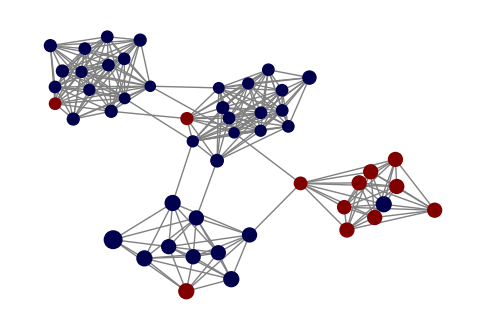

In [218]:
f, axs = plt.subplots(1, figsize=(6,4))
options = {
    "node_color": sensitive_group,
    "edge_color": 'grey',
    "width": 1,
    "node_size":1/np.array([itm[1] for itm in dict(G.degree).items()])*800,
    "edge_cmap": plt.cm.seismic,
    "cmap": plt.cm.seismic,
    "with_labels": False,
}
nx.draw(G, pos, **options,ax=axs)
plt.show()

In [219]:
init_total= ermet.group_total_reff(R, sensitive_group)
init_diam= ermet.group_reff_diam(R, sensitive_group)
init_avg_diam = ermet.group_avg_reff_diam(R, sensitive_group)
init_max_bet = ermet.group_max_reff_betweeness(R, G, sensitive_group)
init_avg_bet = ermet.group_avg_reff_betweeness(R, G, sensitive_group)
init_std_bet = ermet.group_std_reff_betweeness(R, G, sensitive_group)

ori_metric_dict = {'total':init_total,
                   'diam':init_diam,
                    'avg_diam':init_avg_diam,
                    'max_bet' :init_max_bet,
                    'avg_bet':init_avg_bet,
                    'std_bet':init_std_bet}

print(f"""
Total Res: 0-> {init_total[0]:.2f}  --  1-> {init_total[1]:.2f} 
Diam Res: 0-> {init_diam[0]:.2f}  --  1-> {init_diam[1]:.2f} 
AVG Diam: 0-> {init_avg_diam[0]:.2f}  --  1-> {init_avg_diam[1]:.2f} 
Max Bet: 0-> {init_max_bet[0]:.2f}  --  1-> {init_max_bet[1]:.2f} 
AVG Bet: 0-> {init_avg_bet[0]:.2f}  --  1-> {init_avg_bet[1]:.2f} 
STD Bet: 0-> {init_std_bet[0]:.2f}  --  1-> {init_std_bet[1]:.2f} 
""")


Total Res: 0-> 29.90  --  1-> 40.65 
Diam Res: 0-> 1.27  --  1-> 1.27 
AVG Diam: 0-> 1.10  --  1-> 1.20 
Max Bet: 0-> 2.86  --  1-> 3.09 
AVG Bet: 0-> 1.97  --  1-> 1.94 
STD Bet: 0-> 0.27  --  1-> 0.35 



In [220]:
def add_links(G, number_of_edges, S, ratio=1, rand = False):
    def create_dicts(keys):
        return {key: [] for key in keys}
    
    metrics = ['total', 'diam', 'avg_diam', 'max_bet', 'avg_bet', 'std_bet']
    strong_data = create_dicts(metrics)
    rand_data = create_dicts(metrics)
    weak_data = create_dicts(metrics)
    aff_weak_data = create_dicts(metrics)
    aff_strong_data = create_dicts(metrics)
    
    G_strong = G.copy()
    G_rand = G.copy()
    G_weak = G.copy()
    
    G_aff_weak= G.copy()
    G_aff_strong = G.copy()
        
    for i in tqdm(range(number_of_edges+1)):
        
        #Strong
        cos_res_strong = ermet.effective_resistance_matrix(G_strong)
        total= ermet.group_total_reff(cos_res_strong, S)
        diam= ermet.group_reff_diam(cos_res_strong, S)
        avg_diam = ermet.group_avg_reff_diam(cos_res_strong, S)
        max_bet = ermet.group_max_reff_betweeness(cos_res_strong, G_strong, S)
        avg_bet = ermet.group_avg_reff_betweeness(cos_res_strong, G_strong, S)
        std_bet = ermet.group_std_reff_betweeness(cos_res_strong, G_strong, S)
        #save data
        strong_data["total"].append(total)
        strong_data["diam"].append(diam)
        strong_data["avg_diam"].append(avg_diam)
        strong_data["max_bet"].append(max_bet)
        strong_data["avg_bet"].append(avg_bet)
        strong_data["std_bet"].append(std_bet)
        
        #Random
        if rand:
            cos_res_rand = ermet.effective_resistance_matrix(G_rand)
            total= ermet.group_total_reff(cos_res_rand, S)
            diam= ermet.group_reff_diam(cos_res_rand, S)
            avg_diam = ermet.group_avg_reff_diam(cos_res_rand, S)
            max_bet = ermet.group_max_reff_betweeness(cos_res_rand, G_rand, S)
            avg_bet = ermet.group_avg_reff_betweeness(cos_res_rand, G_rand, S)
            std_bet = ermet.group_std_reff_betweeness(cos_res_rand, G_rand, S)
            #save data
            rand_data["total"].append(total)
            rand_data["diam"].append(diam)
            rand_data["avg_diam"].append(avg_diam)
            rand_data["max_bet"].append(max_bet)
            rand_data["avg_bet"].append(avg_bet)
            rand_data["std_bet"].append(std_bet) 
        
        
        if i % ratio == 0:
            cos_res_weak = ermet.effective_resistance_matrix(G_weak)
            total= ermet.group_total_reff(cos_res_weak, S)
            diam= ermet.group_reff_diam(cos_res_weak, S)
            avg_diam = ermet.group_avg_reff_diam(cos_res_weak, S)
            max_bet = ermet.group_max_reff_betweeness(cos_res_weak, G_weak, S)
            avg_bet = ermet.group_avg_reff_betweeness(cos_res_weak, G_weak, S)
            std_bet = ermet.group_std_reff_betweeness(cos_res_weak, G_weak, S)
            #save data
            weak_data["total"].append(total)
            weak_data["diam"].append(diam)
            weak_data["avg_diam"].append(avg_diam)
            weak_data["max_bet"].append(max_bet)
            weak_data["avg_bet"].append(avg_bet)
            weak_data["std_bet"].append(std_bet) 
            
            
            cos_res_aff_weak = ermet.effective_resistance_matrix(G_aff_weak)
            total= ermet.group_total_reff(cos_res_aff_weak, S)
            diam= ermet.group_reff_diam(cos_res_aff_weak, S)
            avg_diam = ermet.group_avg_reff_diam(cos_res_aff_weak, S)
            max_bet = ermet.group_max_reff_betweeness(cos_res_aff_weak, G_aff_weak, S)
            avg_bet = ermet.group_avg_reff_betweeness(cos_res_aff_weak, G_aff_weak, S)
            std_bet = ermet.group_std_reff_betweeness(cos_res_aff_weak, G_aff_weak, S)
            #save data
            aff_weak_data["total"].append(total)
            aff_weak_data["diam"].append(diam)
            aff_weak_data["avg_diam"].append(avg_diam)
            aff_weak_data["max_bet"].append(max_bet)
            aff_weak_data["avg_bet"].append(avg_bet)
            aff_weak_data["std_bet"].append(std_bet)

            
            
            cos_res_aff_strong = ermet.effective_resistance_matrix(G_aff_strong)
            total= ermet.group_total_reff(cos_res_aff_strong, S)
            diam= ermet.group_reff_diam(cos_res_aff_strong, S)
            avg_diam = ermet.group_avg_reff_diam(cos_res_aff_strong, S)
            max_bet = ermet.group_max_reff_betweeness(cos_res_aff_strong, G_aff_strong, S)
            avg_bet = ermet.group_avg_reff_betweeness(cos_res_aff_strong, G_aff_strong, S)
            std_bet = ermet.group_std_reff_betweeness(cos_res_aff_strong, G_aff_strong, S)
            #save data
            aff_strong_data["total"].append(total)
            aff_strong_data["diam"].append(diam)
            aff_strong_data["avg_diam"].append(avg_diam)
            aff_strong_data["max_bet"].append(max_bet)
            aff_strong_data["avg_bet"].append(avg_bet)
            aff_strong_data["std_bet"].append(std_bet)
            
        
        
        #add links
        G_strong = rew.add_strong_link(G_strong, cos_res_strong)
        if rand:
            G_rand = rew.add_rand_link(G_rand, cos_res_rand)
        if i % ratio == 0:
            G_weak = rew.add_weak_link(G_weak, cos_res_weak)
            G_aff_weak = rew.add_weak_affirmative_link(G_aff_weak, CT = cos_res_aff_weak, S=S)
            G_aff_strong = rew.add_strong_affirmative_link(G_aff_strong, CT =  cos_res_aff_strong, S=S)
        
        
    if rand:
        return G_strong, G_weak, G_rand, strong_data, weak_data, rand_data
    else:
        return [G_strong, G_weak, G_aff_weak, G_aff_strong], [strong_data, weak_data, aff_weak_data, aff_strong_data]

In [221]:
N_LINKS = 5
Graphs, data = add_links(G, N_LINKS, sensitive_group)
G_s, G_w, G_aw, G_as = Graphs
d_s, d_w, d_aw, d_as = data

  0%|          | 0/6 [00:00<?, ?it/s]

In [222]:
G.number_of_edges(),G_s.number_of_edges(),G_w.number_of_edges(), G_aw.number_of_edges(), G_as.number_of_edges()

(259, 265, 265, 265, 265)

In [223]:
methods = ['strong', 'weak', 'AARS', 'strong AA']
colors = {'strong': 'red', 'weak':'blue', 'AARS':'green','strong AA':'orange'}
metrics = ['total', 'diam', 'avg_diam', 'max_bet', 'avg_bet', 'std_bet']
result_dict = dict(zip(methods,data))

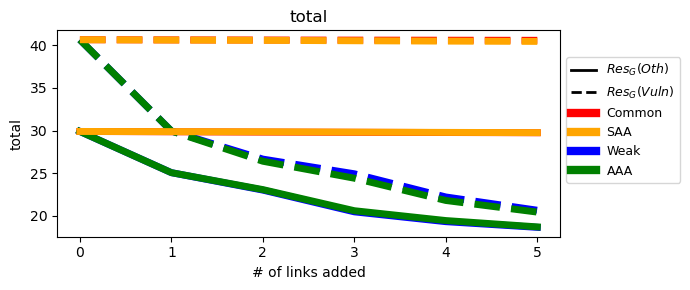

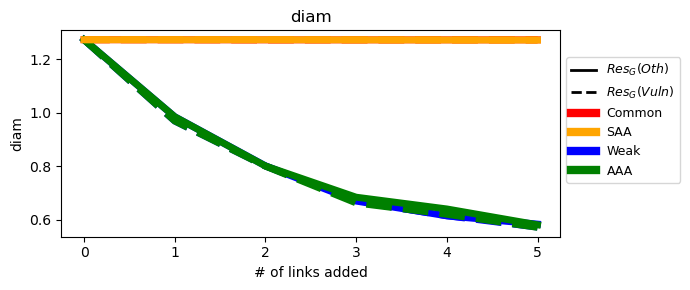

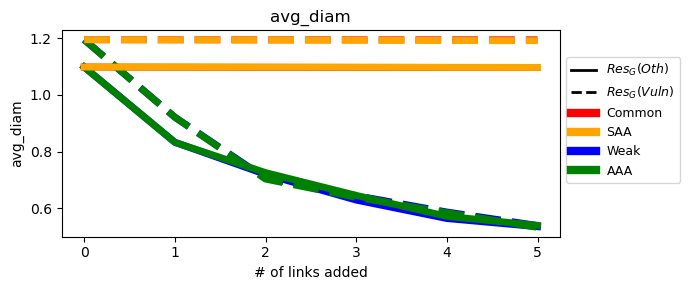

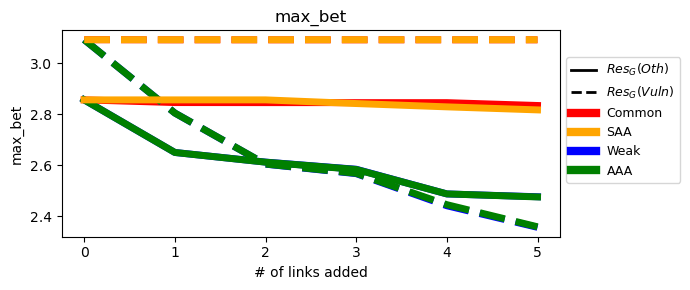

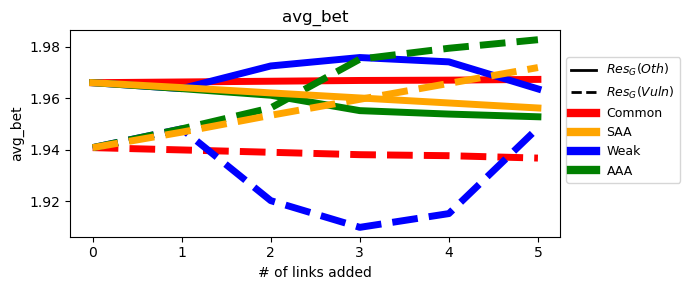

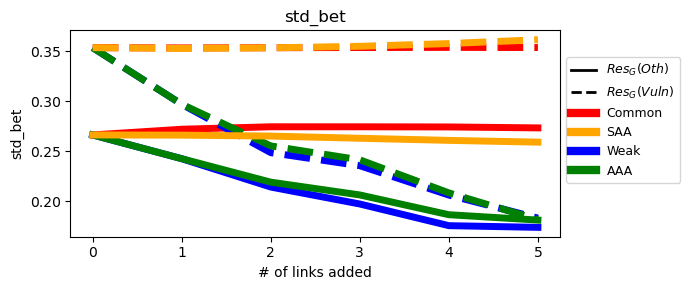

In [224]:
from matplotlib.lines import Line2D   
for metric in metrics:
    f, axs = plt.subplots(1, figsize=(7,3))
    for alg in methods:
        plt.plot([d[0] for d in result_dict[alg][metric]],linewidth='5', color=colors[alg], linestyle="-")
        plt.plot([d[1] for d in result_dict[alg][metric]],linewidth='5', color=colors[alg], linestyle="--")
        
        
    legend_elements = [Line2D([0], [0], linestyle='-', color='black', label=r'$Res_G(Oth)$',linewidth='2'),
                   Line2D([0], [0], linestyle='--', color='black', label='$Res_G(Vuln)$',linewidth='2'),
                   Line2D([0], [0], linestyle='-', color='red', label='Common',linewidth='6'),
                   Line2D([0], [0], linestyle='-', color='orange', label='SAA',linewidth='6'),
                   Line2D([0], [0], linestyle='-', color='blue', label='Weak',linewidth='6'),
                   Line2D([0], [0], linestyle='-', color='green', label='AAA',linewidth='6')
                  ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.0, 0.9), loc="upper left", fontsize=9)
    plt.ylabel(metric)
    plt.xlabel('# of links added')
    plt.title(metric)
    plt.tight_layout()
    plt.show()
    
    
        

    

Mejora de las medidas

In [225]:
for metric in metrics:
    print()
    print('------------------------')
    print(metric)
    for alg in methods:
        print(alg)
        print('\t', result_dict[alg][metric][-1][0]-ori_metric_dict[metric][0], end='   -   ')
        print('\t', result_dict[alg][metric][-1][1]-ori_metric_dict[metric][1])


------------------------
total
strong
	 -0.1498021718292044   -   	 -0.07075553727629824
weak
	 -11.233850304132826   -   	 -19.97769426530599
AARS
	 -11.181356051819286   -   	 -20.19685354669231
strong AA
	 -0.13857274872666991   -   	 -0.19692191919937585

------------------------
diam
strong
	 -0.00047933482273232464   -   	 -0.0004793348227849492
weak
	 -0.6904613458334575   -   	 -0.7015892391914843
AARS
	 -0.6929117859120866   -   	 -0.7025399301426922
strong AA
	 -0.0011639629265669527   -   	 -0.0011639629266153584

------------------------
avg_diam
strong
	 -0.0017969439212415228   -   	 -0.0004400456362829708
weak
	 -0.5645776545466262   -   	 -0.6572421107233826
AARS
	 -0.5600544858967518   -   	 -0.6636429573604048
strong AA
	 -0.0013702099591843542   -   	 -0.003470430635338362

------------------------
max_bet
strong
	 -0.02200908826891501   -   	 -0.0004160765779972486
weak
	 -0.38034924074394194   -   	 -0.73673405275547
AARS
	 -0.38110657424728167   -   	 -0.73455976

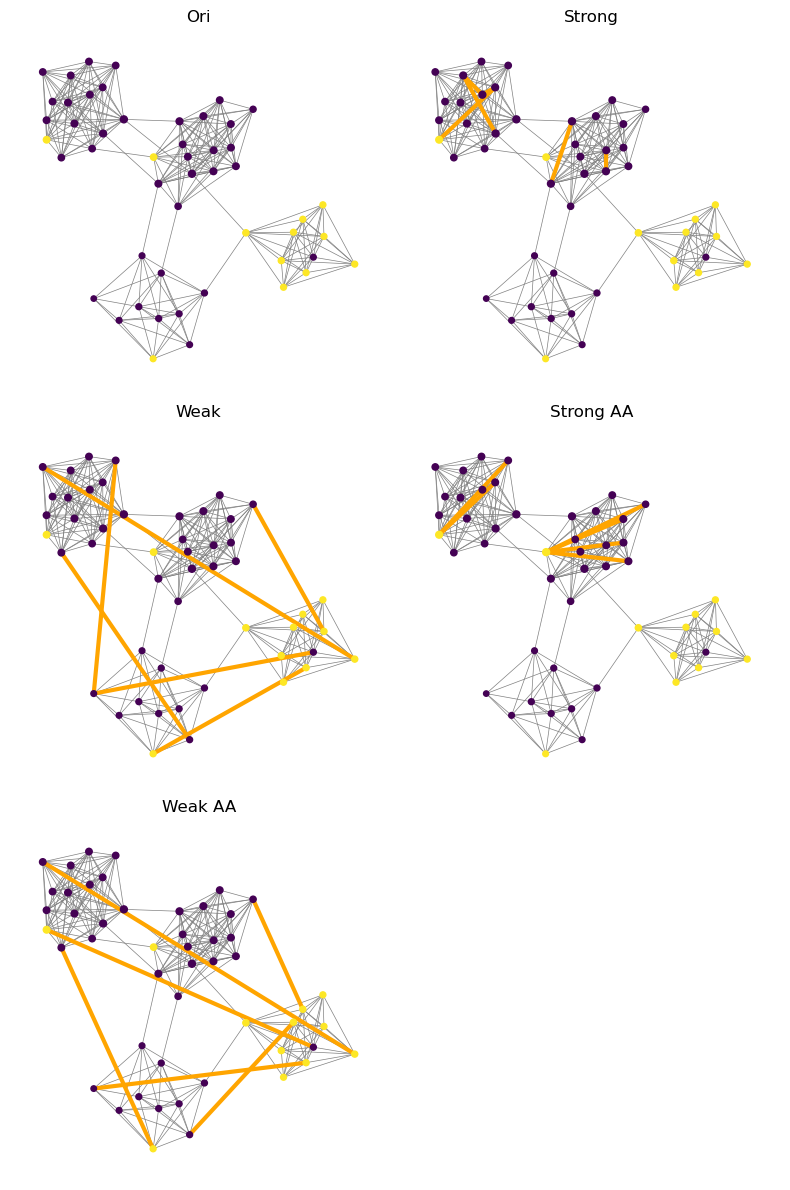

In [226]:
vis.print_several_graphs([G, G_s, G_w, G_as, G_aw],
                     node_color=sensitive_group,
                     base_G=0,
                     names=['Ori','Strong', 'Weak', 'Strong AA', 'Weak AA'],
                     pos=pos)

In [231]:
from karateclub import DeepWalk
#https://towardsdatascience.com/introduction-to-graph-neural-networks-with-deepwalk-f5ac25900772
G_dw_s = G.copy()

for _ in range(N_LINKS+1):
    dw = DeepWalk(dimensions=32)
    dw.fit(G_dw_s.copy())
    Z = dw.get_embedding()
    S = np.dot(Z, Z.T)
    np.fill_diagonal(S,0)
    G_dw_s = rew.add_weak_link(G_dw_s, CT=S)

G_dw_w = G.copy()
for _ in range(N_LINKS+1):
    dw = DeepWalk(dimensions=5)
    dw.fit(G_dw_w.copy())
    Z = dw.get_embedding()
    S = np.dot(Z, Z.T)
    np.fill_diagonal(S,0)
    G_dw_w = rew.add_strong_link(G_dw_w, CT=S)

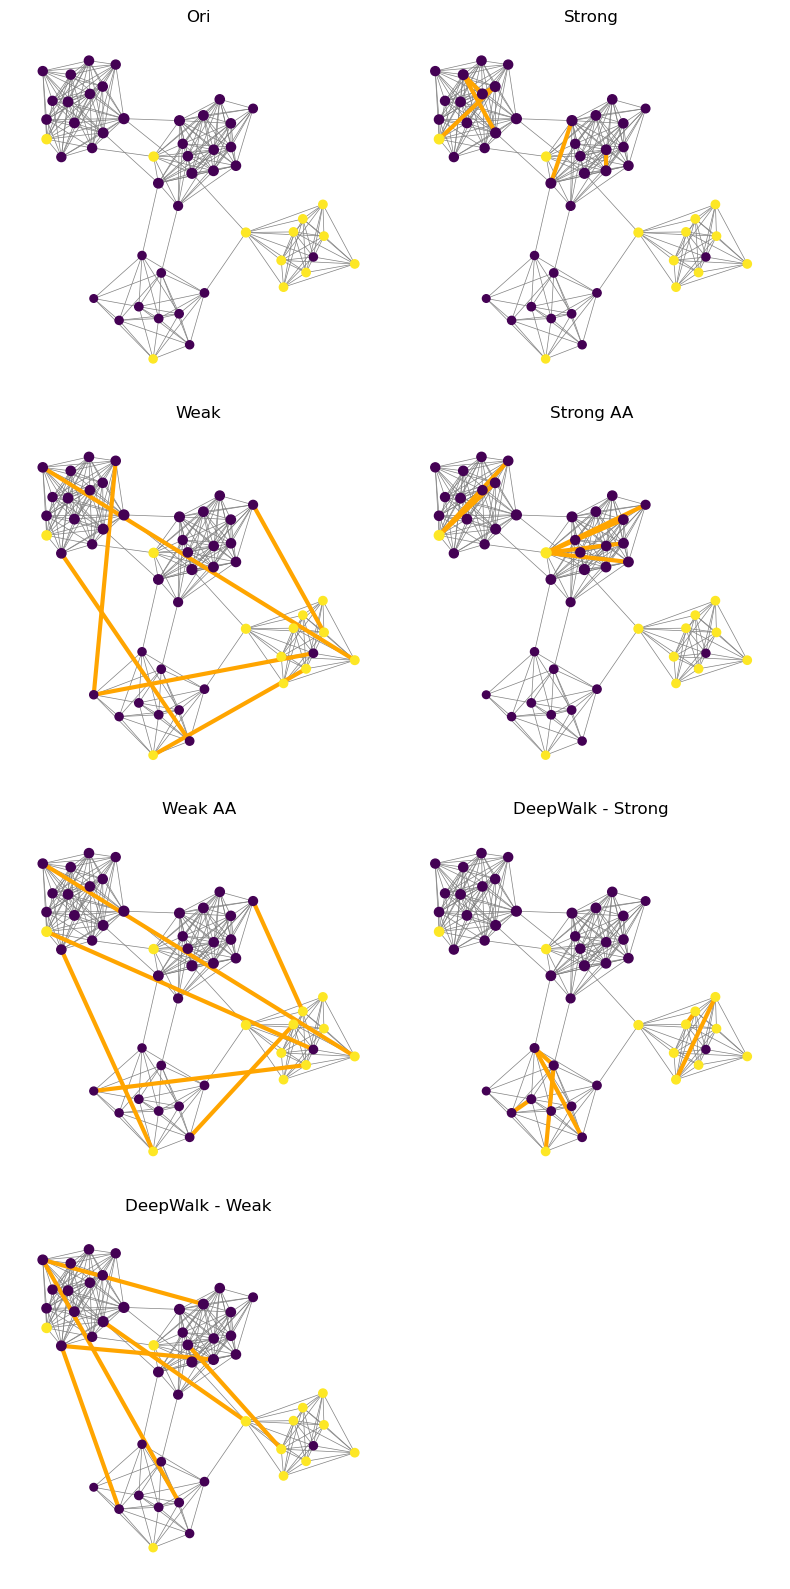

In [232]:
vis.print_several_graphs([G, G_s, G_w, G_as, G_aw, G_dw_s, G_dw_w],
                     node_color=sensitive_group,
                     base_G=0,
                     names=['Ori','Strong', 'Weak', 'Strong AA', 'Weak AA', 'DeepWalk - Strong', 'DeepWalk - Weak'],
                     node_size=2,
                     pos=pos)

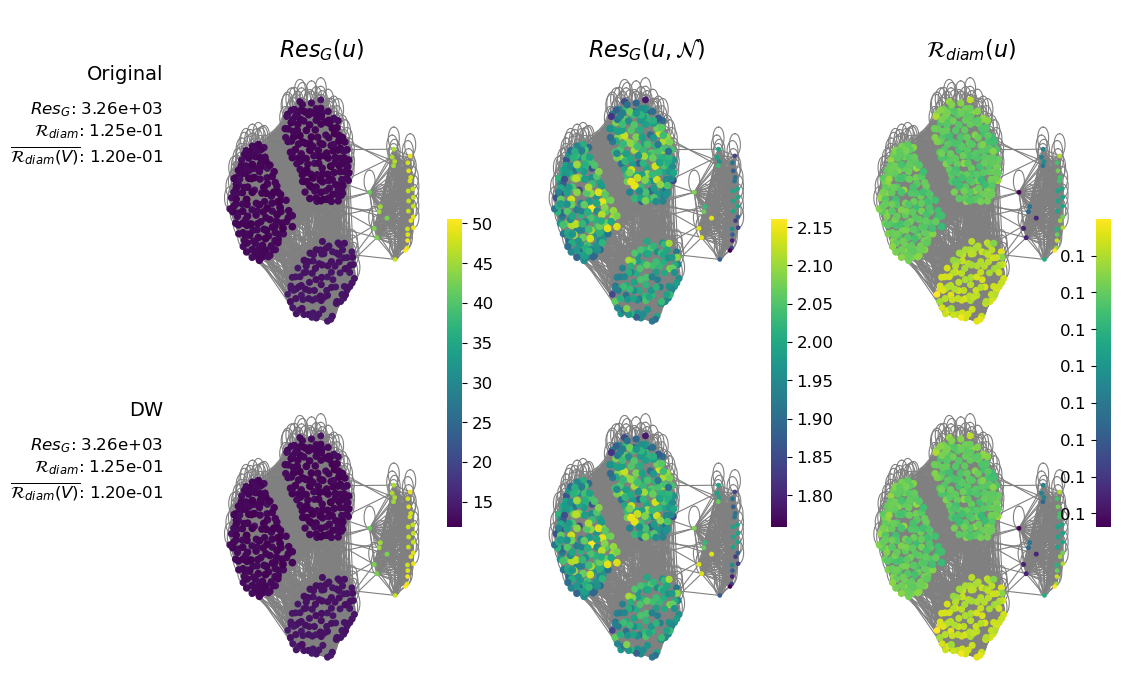

In [162]:
compare_graphs([G, G_s, G_w, G_aw, G_as],
               graph_names=['Original', 'Strong', 'Weak', 'AAA', 'SAA'], 
              edge_highlight=True, node_size=0.2,
              save=False)

Compare graphs

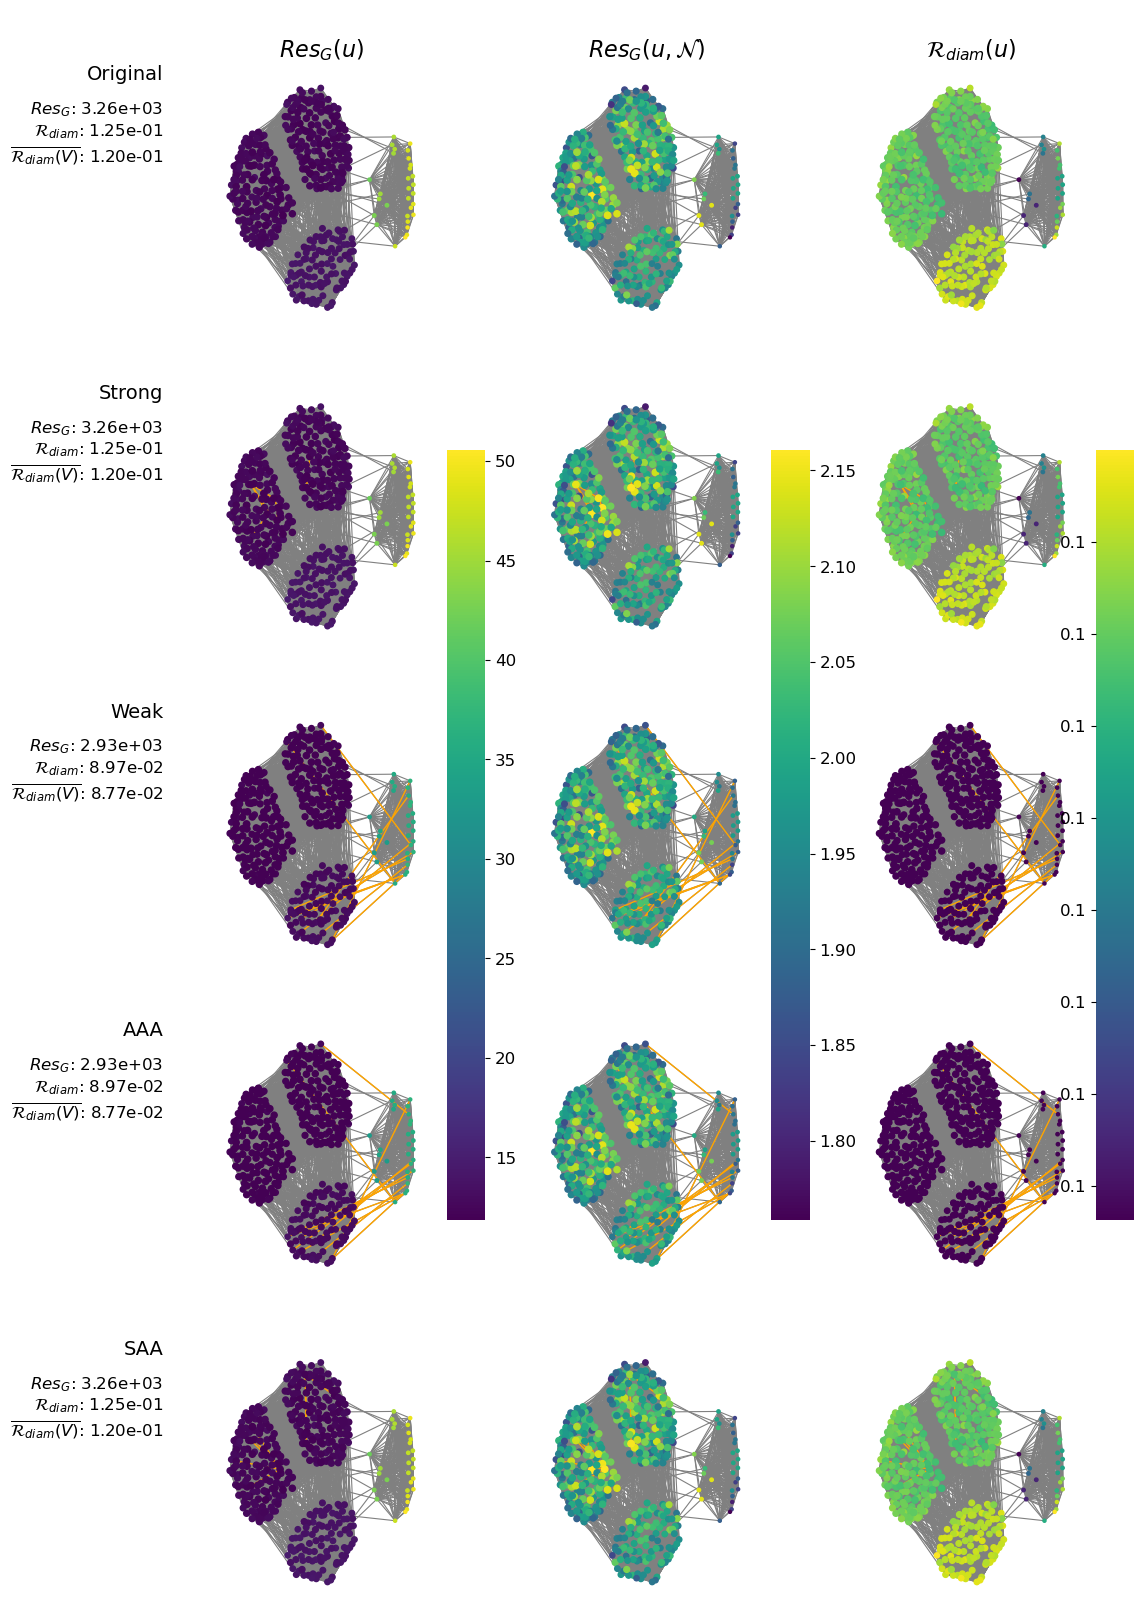

In [102]:
compare_graphs([G, G_s, G_w, G_aw, G_as],
               graph_names=['Original', 'Strong', 'Weak', 'AAA', 'SAA'], 
              edge_highlight=True, node_size=0.2,
              save=False)

In [101]:
G1 = G_s
G2 = G_w
G3 = G_s

In [ ]:
ori_cos_res = ermet.effective_resistance_matrix(G)
strong_cos_res = ermet.effective_resistance_matrix(G1)
weak_cos_res = ermet.effective_resistance_matrix(G2)
rand_cos_res = ermet.effective_resistance_matrix(G3)
all_res = [squareform(ori_cos_res.round(5)),
           squareform(strong_cos_res.round(5)),
           squareform(weak_cos_res.round(5)),
           squareform(rand_cos_res.round(5))]

ori_node_total_res = ermet.node_total_er(ori_cos_res)
strong_node_total_res = ermet.node_total_er(strong_cos_res)
weak_node_total_res = ermet.node_total_er(weak_cos_res)
rand_node_total_res = ermet.node_total_er(rand_cos_res)
all_total_res = [ori_node_total_res, strong_node_total_res,
                 weak_node_total_res, rand_node_total_res]

ori_node_total_filtered_res = ermet.node_total_er(ori_cos_res, G, filtered=True)
strong_node_total_filtered_res = ermet.node_total_er(strong_cos_res, G1, filtered=True)
weak_node_total_filtered_res = ermet.node_total_er(weak_cos_res, G2, filtered=True)
rand_node_total_filtered_res = ermet.node_total_er(rand_cos_res, G3, filtered=True)
all_filtered_res = [ori_node_total_filtered_res, strong_node_total_filtered_res,
                   weak_node_total_filtered_res, rand_node_total_filtered_res]

ori_diam_total_res = ermet.node_diameters(ori_cos_res)
strong_diam_total_res = ermet.node_diameters(strong_cos_res)
weak_diam_total_res = ermet.node_diameters(weak_cos_res)
rand_diam_total_res = ermet.node_diameters(rand_cos_res)
all_diam_res = [ori_diam_total_res, strong_diam_total_res,
               weak_diam_total_res, rand_diam_total_res]

In [ ]:
import pandas as pd

In [ ]:
all_total_res_0 = [ls[sensitive_group==0] for ls in all_total_res]
all_filtered_res_0 = [ls[sensitive_group==0] for ls in all_filtered_res]
all_diam_res_0 = [ls[sensitive_group==0] for ls in all_diam_res]

all_total_res_1 = [ls[sensitive_group==1] for ls in all_total_res]
all_filtered_res_1 = [ls[sensitive_group==1] for ls in all_filtered_res]
all_diam_res_1 = [ls[sensitive_group==1] for ls in all_diam_res]

In [ ]:
df_res0 = pd.DataFrame(all_res).transpose()
df_res0.columns = ['Original', 'Strong', 'IF-AA', 'Random']
df_total0 = pd.DataFrame(all_total_res_0).transpose()
df_total0.columns = ['Original', 'Strong', 'IF-AA', 'Random']
df_tot_filter0 = pd.DataFrame(all_filtered_res_0).transpose()
df_tot_filter0.columns = ['Original', 'Strong', 'IF-AA', 'Random']
df_diam0 = pd.DataFrame(all_diam_res_0).transpose()
df_diam0.columns = ['Original', 'Strong', 'IF-AA', 'Random']

df_res1 = pd.DataFrame(all_res).transpose()
df_res1.columns = ['Original', 'Strong', 'IF-AA', 'Random']
df_total1 = pd.DataFrame(all_total_res_1).transpose()
df_total1.columns = ['Original', 'Strong', 'IF-AA', 'Random']
df_tot_filter1 = pd.DataFrame(all_filtered_res_1).transpose()
df_tot_filter1.columns = ['Original', 'Strong', 'IF-AA', 'Random']
df_diam1 = pd.DataFrame(all_diam_res_1).transpose()
df_diam1.columns = ['Original', 'Strong', 'IF-AA', 'Random']

In [ ]:
vis.plot_violins_node_metrics(df_res0, df_total0, df_tot_filter0, df_diam0)

In [ ]:
vis.plot_violins_node_metrics(df_res1, df_total1, df_tot_filter1, df_diam1)

In [ ]:
vis.plot_violins_node_metrics_by_group([G, G1, G2], names=['Ori','STRONG', 'WEAK'],S=sensitive_group)

In [ ]:
R = ermet.effective_resistance_matrix(G)
G1= rew.add_strong_link(G, R)
G2= rew.add_weak_link(G, R)
G3= rew.add_weak_affirmative_link(G, CT=R, S=sensitive_group)
G4 = rew.add_strong_affirmative_link(G, CT=R, S=sensitive_group)
G.number_of_edges(), G1.number_of_edges(), G2.number_of_edges(), G3.number_of_edges()

In [ ]:
f, axs = plt.subplots(1, figsize=(6,4))
nx.draw(G, pos, **options,ax=axs)

## TODOS

* All algorithms

In [ ]:
np.where(sensitive_group==1)